# Comparison of Regressors for Abalone Age Prediction

## Om datasettet
Datasettet Abalone inneholder eksemplarer av Abalone, som er en en type skalldyr. For å bestemme alderen på Abalone, må man skjære opp skallet og telle ringene på insiden pluss 1.5 år. Prosesyren er både tidkrevende og ødeleggende for eksemplaret. 

Formålet med datasettet er å kunne forutsi antall ringer som en Abalone har basert på fysiske målinger ved hjelp av maskinlæring. 

Datasettet inneholder 4177 observasjoner, med 8 features og en målkolonne med antall ringer. Variablene i datasettet numeriske (heltall eller flyttall) eller kategoriske.

### Datasettet inneholder:
- **Sex:** Kategorisk, Kjønnet til skalldyret
- **Length:** Flyttall, Den lengste lengden målt på skjellet målt i mm
- **Diameter:** Flyttall, Diameteren vinkelrett på lengden målt i mm
- **Height:** Flyttall, Høyde med kjøttet i skallet målt i mm
- **Whole weight:** Flyttall, Vekten av hele skalldyret målt i g
- **Shucked wheight:** Flyttall, Vekten av kjøttet målt i g
- **Viscera weight:** Flyttall, Vekten av innvoldene etter blødning målt i g
- **Shell weight:** Flyttall, Vekten av skallet etter det er tørket målt i g
- **Rings:** Heltall, Antall ringer i skallet. +1.5 år gir alderen på skalldyret

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, get_scorer
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization, Input
from tensorflow.keras.models import Sequential
from scikeras.wrappers import KerasRegressor

## Analyse og preprosessering av datasettet

In [3]:
columns = ["Sex", "Length", "Diameter", "Height", "Whole weight", "Shucked weight", "Viscera weight", "Shell weight", "Rings"]
dataset = pd.read_csv("abalone.data", header=None, names=columns)

encoder = OneHotEncoder(sparse_output=False, drop="first")
encoded = encoder.fit_transform(dataset[["Sex"]])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(["Sex"]))
dataset = pd.concat([dataset.drop(columns=["Sex"]), encoded_df], axis=1)

dataset.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0.0,1.0
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0.0,1.0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0.0,0.0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0.0,1.0
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,1.0,0.0


Brukte OneHotEncoder for å gjøre variablen numerisk, slik at jeg kan bruke kolonnen "Sex" til å finne lineær sammenheng uten at modellene skal tolke kategoriene som rangerte tallverdier. Dette fører til at kolonnen blir splittet i to nye. Tre kolonner vil være unødvendig ettersom 0 i begge kolonner vil indikere det samme som om det hadde vært en tredje kolonne.

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Length          4177 non-null   float64
 1   Diameter        4177 non-null   float64
 2   Height          4177 non-null   float64
 3   Whole weight    4177 non-null   float64
 4   Shucked weight  4177 non-null   float64
 5   Viscera weight  4177 non-null   float64
 6   Shell weight    4177 non-null   float64
 7   Rings           4177 non-null   int64  
 8   Sex_I           4177 non-null   float64
 9   Sex_M           4177 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 326.5 KB


### Manglende verdier og duplikater

In [5]:
missing_values = int(dataset.isna().sum().sum())
duplicate_values = int(dataset.isna().sum().sum())
print(f"Antall manglende verdier i datasettet: {missing_values}")
print(f"Antall duplikat-rader: {duplicate_values}")

Antall manglende verdier i datasettet: 0
Antall duplikat-rader: 0


Jeg sjekket at dataen var slik som forventet for datasettet. Antall rader og kolonner er korrekt, det er ingen manglende verdier slik som det står i dokumentasjonen, og heller ingen duplikat-rader

### Klassefordeling

array([[<Axes: title={'center': 'Length'}>,
        <Axes: title={'center': 'Diameter'}>,
        <Axes: title={'center': 'Height'}>],
       [<Axes: title={'center': 'Whole weight'}>,
        <Axes: title={'center': 'Shucked weight'}>,
        <Axes: title={'center': 'Viscera weight'}>],
       [<Axes: title={'center': 'Shell weight'}>,
        <Axes: title={'center': 'Rings'}>,
        <Axes: title={'center': 'Sex_I'}>],
       [<Axes: title={'center': 'Sex_M'}>, <Axes: >, <Axes: >]],
      dtype=object)

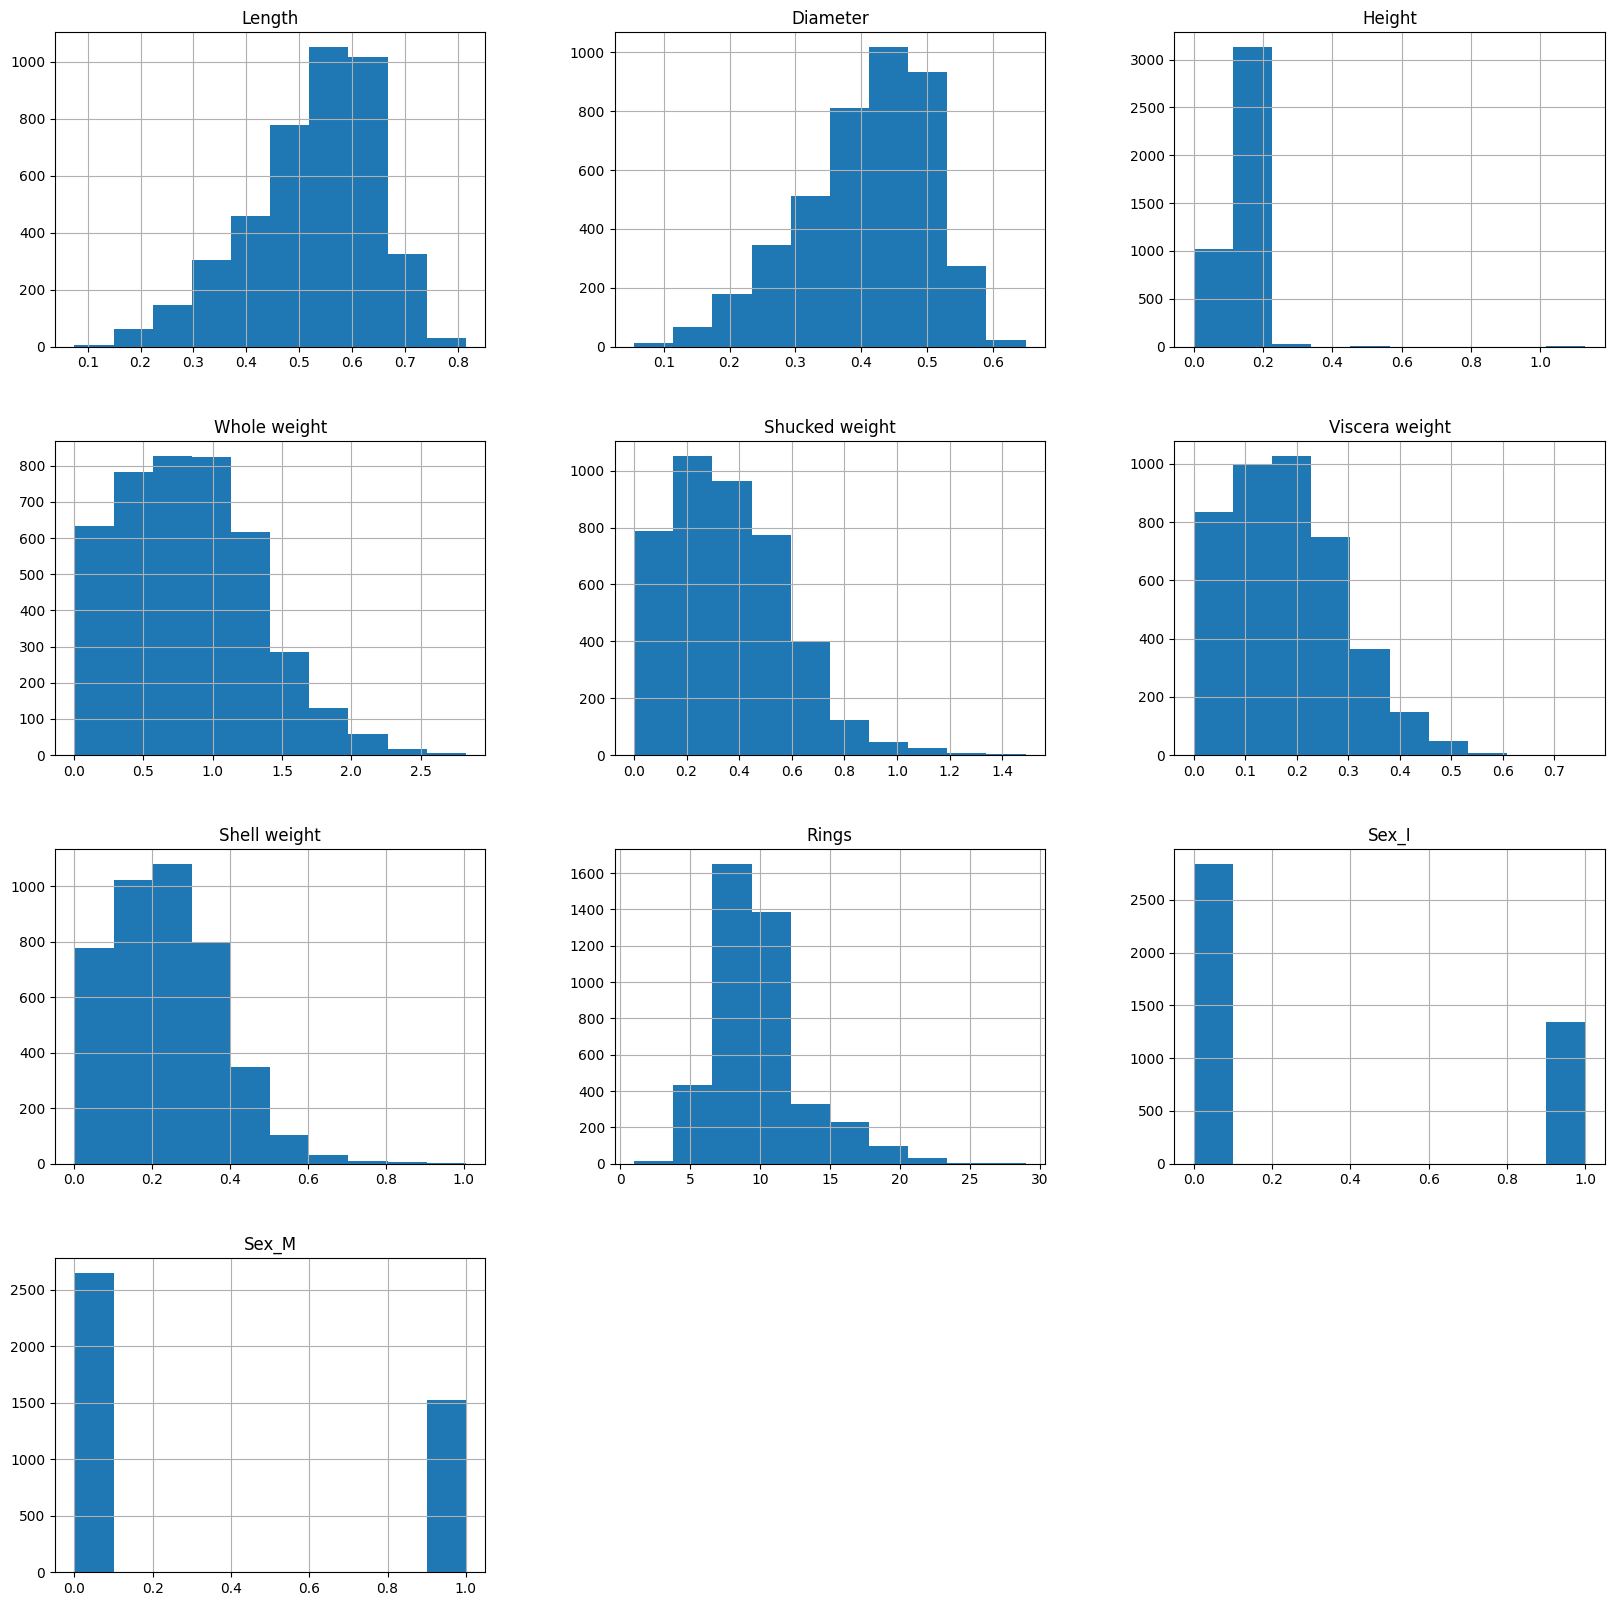

In [6]:
dataset_features = dataset.drop("Rings", axis=1)
dataset_targets = dataset["Rings"]
dataset.hist(figsize=(20,20))

In [7]:
dataset["Rings"].value_counts()

Rings
9     689
10    634
8     568
11    487
7     391
12    267
6     259
13    203
14    126
5     115
15    103
16     67
17     58
4      57
18     42
19     32
20     26
3      15
21     14
23      9
22      6
27      2
24      2
1       1
26      1
29      1
2       1
25      1
Name: count, dtype: int64

Datasettets målkolonne er litt høyeskjevt, men ikke så langt unna normalfordeling, med unntak av noen uteliggere. Feature verdiene er også relativt høyreskjeve, med unntak av Length og Diameter som er er litt venstreskjeve.

Ettersom noen features er høyreskjeve så vil jeg teste log-transformasjon av disse, nemlig på "Whole weight", "Shuckled weight", Viscera weight", "Shell weight" og "Height". "Length" og "Diameter" er kun moderat venstreskjeve, så disse beholder jeg som de er. "Sex_I" og "Sex_M" er binære, så her vil jeg heller ikke gjøre noen endring. Dette vil jeg kun gjøre på de lineære modellene, ettersom det ikke er hensiktsmessig å gjøre på de andre.

For målvariabelen vil jeg forsøke med log-transformasjoner for de lineære modellene, ettersom disse blir mest påvirket av en skjev fordeling.

For skalldyrene med 1, 2, 25, 26, og 29 ringer finnes det kun 1 observasjon. Om jeg skulle brukt klassifisering så ville det vært for lite til å gi informasjon til modellene, men ettersom det er regresjon så går det fint.

In [8]:
dataset.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_I,Sex_M
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684,0.321283,0.365813
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169,0.467025,0.481715
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000,0.000000,0.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000,0.000000,0.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000,0.000000,0.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000,1.000000,1.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000,1.000000,1.000000


### Heatmap for korrelasjon

In [9]:
categorical_features_correlation = dataset_features.corr()
categorical_features_correlation.style.background_gradient(cmap="coolwarm")

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Sex_I,Sex_M
Length,1.000000,0.986812,0.827554,0.925261,0.897914,0.903018,0.897706,-0.551465,0.236543
Diameter,0.986812,1.000000,0.833684,0.925452,0.893162,0.899724,0.905330,-0.564315,0.240376
Height,0.827554,0.833684,1.000000,0.819221,0.774972,0.798319,0.817338,-0.518552,0.215459
Whole weight,0.925261,0.925452,0.819221,1.000000,0.969405,0.966375,0.955355,-0.557592,0.252038
Shucked weight,0.897914,0.893162,0.774972,0.969405,1.000000,0.931961,0.882617,-0.521842,0.251793
Viscera weight,0.903018,0.899724,0.798319,0.966375,0.931961,1.000000,0.907656,-0.556081,0.242194
Shell weight,0.897706,0.905330,0.817338,0.955355,0.882617,0.907656,1.000000,-0.546953,0.235391
Sex_I,-0.551465,-0.564315,-0.518552,-0.557592,-0.521842,-0.556081,-0.546953,1.000000,-0.522541
Sex_M,0.236543,0.240376,0.215459,0.252038,0.251793,0.242194,0.235391,-0.522541,1.000000


Mange features vises ser å være svært sterkt korrelert, og kun "Sex_i" viser negativ korrelasjon med alle andre features. "Diameter" og "Length" har en korrelasjon på 0.987, noe som tilsvarer at de nesten gir helt lik informasjon. Det samme gjelder "Whole weight" og "Shucked weight" med korrelasjon på 0.969, "Whole weight" og "Viscera weight" med korrelasjon på 0.966, "Whole weight" og "Shell weight" med korrelasjon på 0.955. I tillegg til disse så er det også høy korrelasjon mellom flere andre features.

Dette forteller at det kan være hensiktsmessig å gjøre en PCA-analyse for å finne ut om jeg kan redusere antall komponenter.

### Skalering av data

In [10]:
scaler = StandardScaler()
standardiced_features = pd.DataFrame(scaler.fit_transform(dataset_features), columns=dataset_features.columns)
standardiced_features.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Sex_I,Sex_M
count,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03
mean,-5.834718e-16,-3.027929e-16,3.912493e-16,9.185853e-17,-1.020650e-17,2.704723e-16,2.976897e-16,-7.144552e-17,1.169495e-17
std,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00
min,-3.739154e+00,-3.556267e+00,-3.335953e+00,-1.686092e+00,-1.614731e+00,-1.643173e+00,-1.705134e+00,-6.880179e-01,-7.594876e-01
25%,-6.161975e-01,-5.833158e-01,-5.862075e-01,-7.897577e-01,-7.811585e-01,-7.946415e-01,-7.819095e-01,-6.880179e-01,-7.594876e-01
50%,1.749513e-01,1.725193e-01,1.156329e-02,-5.963767e-02,-1.052891e-01,-8.753202e-02,-3.470794e-02,-6.880179e-01,-7.594876e-01
75%,7.579031e-01,7.267984e-01,6.093341e-01,6.613049e-01,6.426730e-01,6.606355e-01,6.478319e-01,1.453451e+00,1.316677e+00
max,2.423480e+00,2.440025e+00,2.368329e+01,4.072271e+00,5.085388e+00,5.286500e+00,5.504642e+00,1.453451e+00,1.316677e+00


array([[<Axes: title={'center': 'Length'}>,
        <Axes: title={'center': 'Diameter'}>,
        <Axes: title={'center': 'Height'}>],
       [<Axes: title={'center': 'Whole weight'}>,
        <Axes: title={'center': 'Shucked weight'}>,
        <Axes: title={'center': 'Viscera weight'}>],
       [<Axes: title={'center': 'Shell weight'}>,
        <Axes: title={'center': 'Sex_I'}>,
        <Axes: title={'center': 'Sex_M'}>]], dtype=object)

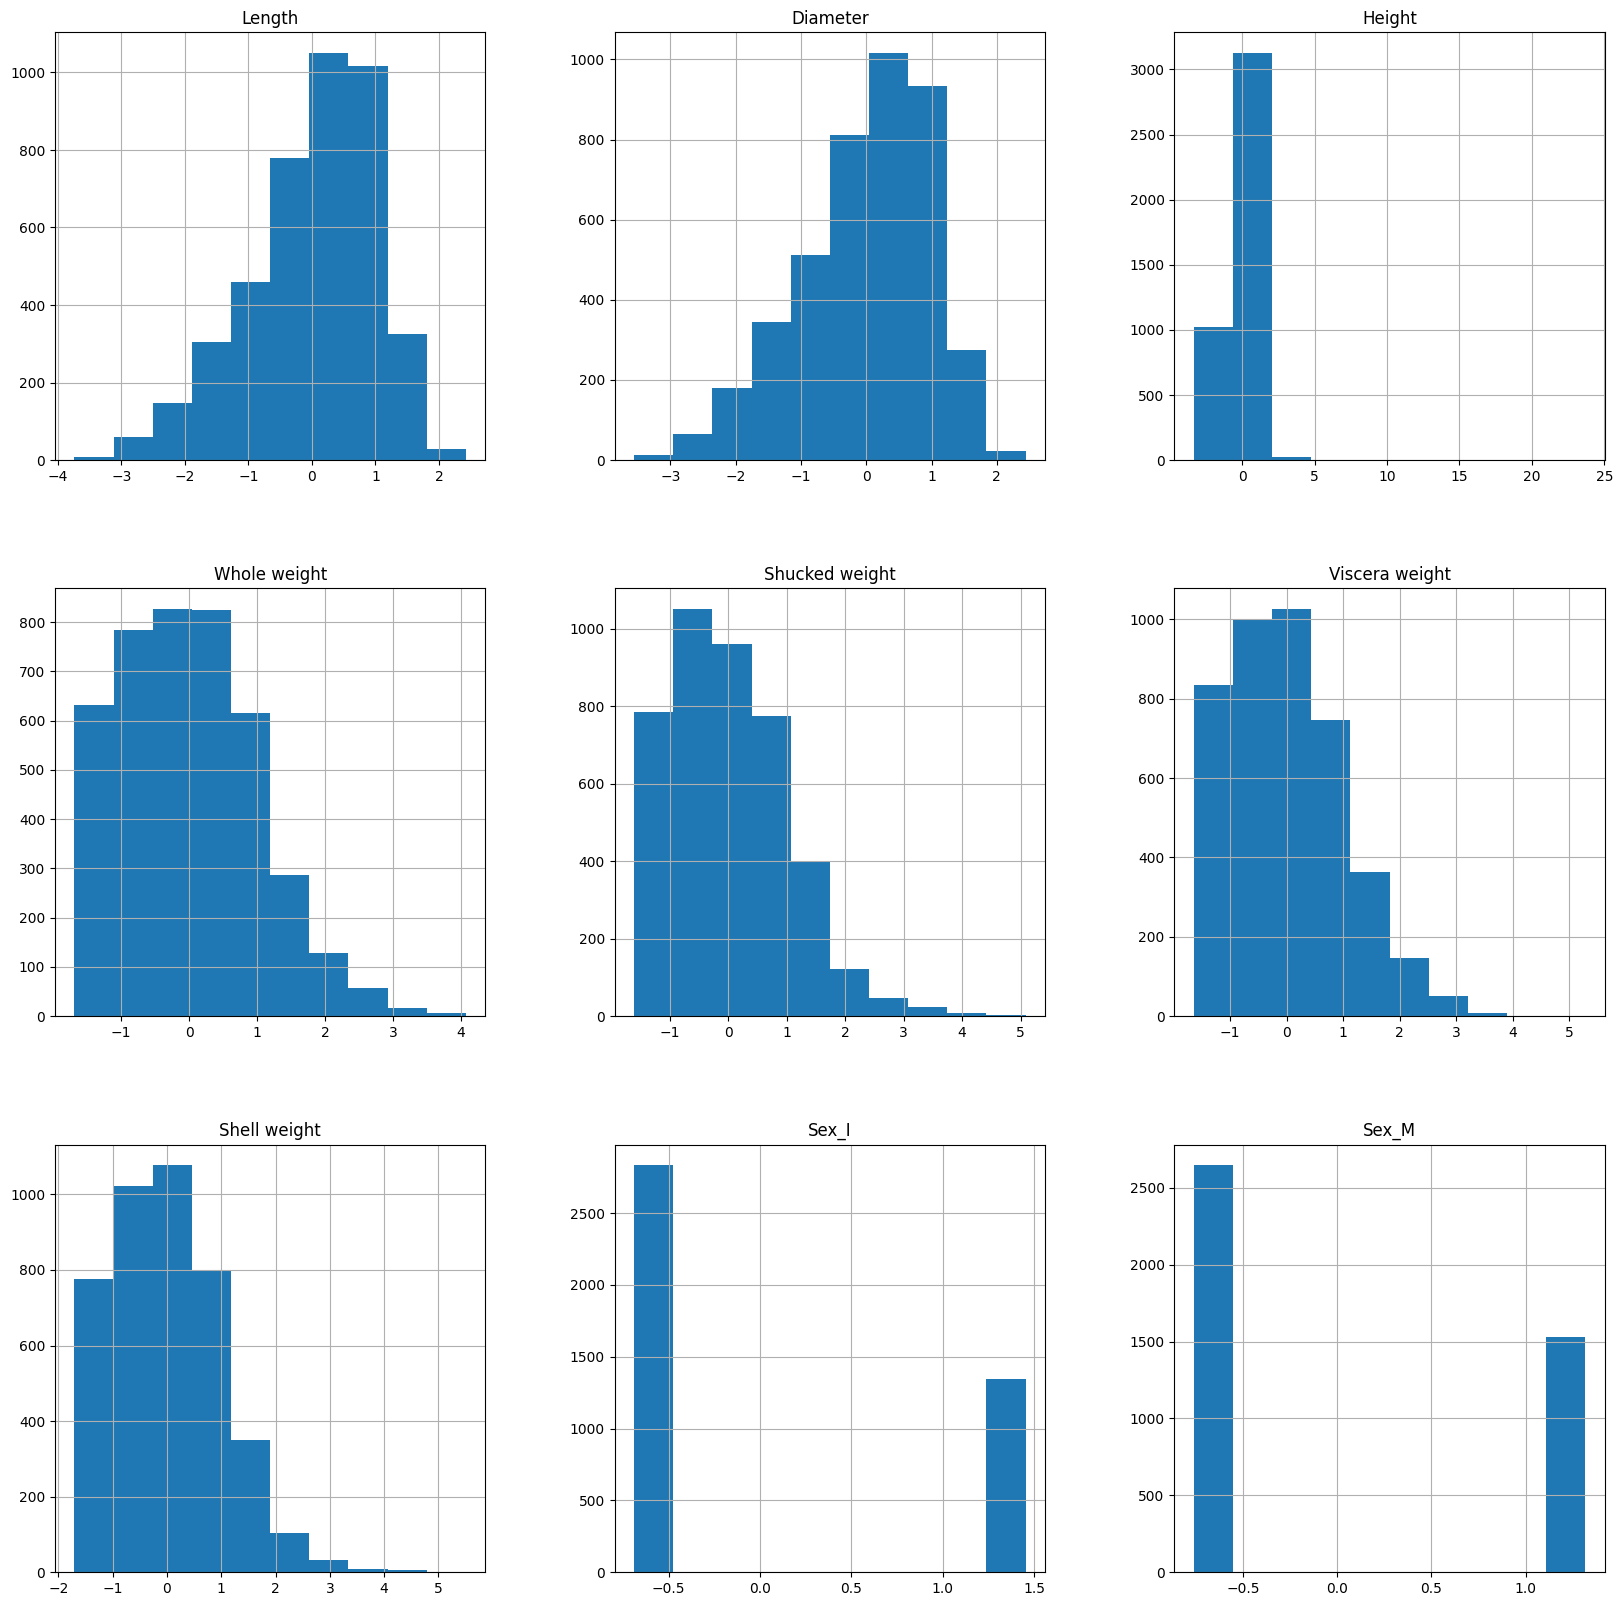

In [11]:
standardiced_features.hist(figsize=(20,20))

Jeg skalerer dataen for å kunne lage en PCA-analyse som gir en indikator på hvor mange komponenter som bør benyttes. Til trening og testing av modeller så vil den ustandardiserte dataen bli standardisert i hver fold slik at det ikke blir datalekkasje.

### PCA-analyse

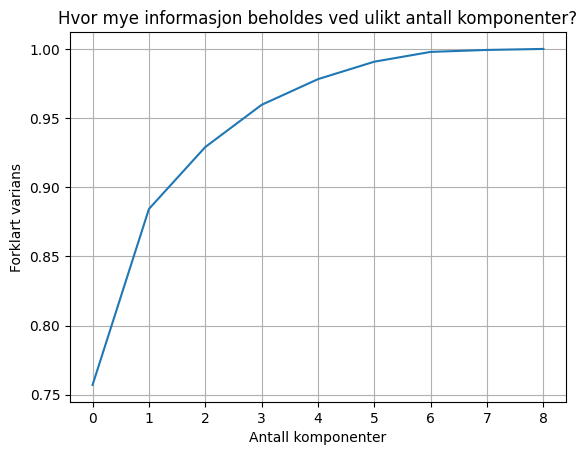

In [12]:
pca = PCA()
pca.fit(standardiced_features)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Antall komponenter')
plt.ylabel('Forklart varians')
plt.title('Hvor mye informasjon beholdes ved ulikt antall komponenter?')
plt.grid(True)
plt.show()

PCA-analyse viser at omtrent all informasjon vil bli beholdt ved 7 og 8 komponenter, men også relativt mye ved 5 og 6. Jeg ønsker derfor å teste disse.

### Funksjon for bygging av tensorflow modell

In [13]:
n_features = dataset_features.shape[1]

def build_tensorflow_model(hidden_neurons1=64, hidden_neurons2=32, dropout_rate=0.0, n_features=n_features):
    model = Sequential()
    model.add(tf.keras.Input(shape=(n_features,)))
    model.add(Dense(hidden_neurons1, activation="relu"))
    model.add(Dense(hidden_neurons2, activation="relu"))

    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation="linear"))

    model.compile(optimizer="adam", loss="mse", metrics=["mse", "mae"])

    return model

In [14]:
def build_tensorflow_model(meta, hidden_layers=(8, 4), dropout_rate=0.0):
    n_features = meta["n_features_in_"]
    n_outputs = meta.get("n_outputs_", 1)

    model = Sequential()
    model.add(tf.keras.Input(shape=(n_features,)))

    for units in hidden_layers:
        model.add(Dense(units, activation="relu"))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    model.add(Dense(n_outputs, activation="linear"))

    model.compile(optimizer="adam", loss="mse", metrics=["mse", "mae"]
    )
    return model

Jeg laget en funksjon som skal bygge et nevralt nettverk med tensorflow som vil bli brukt i KerasRegressor. Funksjonen tar imot antall nevroner antall skjulte lag, samt en dropout_rate. Modellen vil optimalisere MSE, men vil også vise MAE under trening og evaluering.

In [15]:
continious = [
    "Length",
    "Diameter",
    "Height", 
    "Whole weight", 
    "Shucked weight", 
    "Viscera weight", 
    "Shell weight"
]

binary = [
    "Sex_I",
    "Sex_M"
]

features_to_log = [
    "Height", 
    "Whole weight", 
    "Shucked weight", 
    "Viscera weight", 
    "Shell weight"
    ]

In [16]:
scale = ColumnTransformer(
    transformers=[
        ("con", StandardScaler(), continious)
    ],
    remainder="passthrough"
)

log = ColumnTransformer(
    transformers=[
        ('log', FunctionTransformer(np.log1p, feature_names_out='one-to-one'), features_to_log),
    ],
    remainder='passthrough'
)

log_and_scale_pipe = Pipeline([
    ("log", log),
    ("scale", StandardScaler())
])

log_and_scale = ColumnTransformer(
    transformers=[
        ("con", log_and_scale_pipe, continious)
    ],
    remainder="passthrough"
)


Jeg lagde columntransformers for å kunne teste ulike kombinasjoner av preprosessert data i pipelines i riktig rekkefølge.

Jeg tester følgende kombinasjoner:
- **Kun skalering**
- **Kun log**
- **Log og skalering**

### Metrikker som skal måles

In [17]:
scoring = {
    "MAE": get_scorer("neg_mean_absolute_error"),
    "MSE": get_scorer("neg_mean_squared_error"),
    "RMSE": get_scorer("neg_root_mean_squared_error"),
    "R2": get_scorer("r2")
}

Bruker den negative versjonen av metrikkene slik at ikke sklearn skal tolke høyere verdi som bedre.

### Valg av modeller

- **Linear Regression** valgte jeg for å ha en enkel model som en baseline for sammenligning med de andre modellen.

- **Ridge Regressor** valgte jeg ettersom dette er en mer stabil modell enn Linear Regression, siden den blant annet hindrer at koeffisientene blir alt for store. 

- **Random Forest Regressor** er en ikke-lineær regresjonsmodell som vil kunne håndtere ikke-lineære sammenhenger bedre enn de lineære modellene. Den bygger mange tær parallellt.

- **Gradient Boosting Regressor** er også ikke-lineær, men bygger mange mindre trær sekvensielt som lærer av hverandre. Det er en mer avansert modell enn de andre, men vil ofte gi best resultater, så jeg ønsker derfor å ta med denne.

- **MLPRegressor** er en ikke lineær nevralt nettverk-basert regresjonsmodell som kan modellere komplekse sammenhenger ved hjelp av flere skjulte lag med nevroner.

- **KerasRegressor** er også en ikke lineær nevralt nettverk-basert regresjonsmodell som bruker en TensorFlow-modell for å finne komplekse sammenhenger. I denne kan man definere arkitekturen noe mer detaljert enn i MLPRegressor.

### Pipelines for ulike modeller

In [18]:
global_random_state = 13
cv = KFold(n_splits=5, shuffle=True, random_state=global_random_state)

pipelines = {
    'lr_no_processing': Pipeline([
        ('lr', LinearRegression())
    ]),
    'lr_scaled': Pipeline([
        ('scale', scale),
        ('lr', LinearRegression())
    ]),
    'lr_log': Pipeline([
        ('log', log),
        ('lr', LinearRegression())
    ]),
    'lr_log_scaled': Pipeline([
        ('log_scaled', log_and_scale),
        ('lr', LinearRegression())
    ]),

    'ri_no_processing': Pipeline([
        ('ri', Ridge())
    ]),
    'ri_scaled': Pipeline([
        ('scale', scale),
        ('ri', Ridge())
    ]),
    'ri_log': Pipeline([
        ('log', log),
        ('ri', Ridge())
    ]),
    'ri_log_scaled': Pipeline([
        ('log_scaled', log_and_scale),
        ('ri', Ridge())
    ]),

    'rf_no_processing': Pipeline([
        ('rf', RandomForestRegressor(random_state=global_random_state))
    ]),
    'rf_scaled': Pipeline([
        ('scale', scale),
        ('rf', RandomForestRegressor(random_state=global_random_state))
    ]),
    'rf_log': Pipeline([
        ('log', log),
        ('rf', RandomForestRegressor(random_state=global_random_state))
    ]),
    'rf_log_scaled': Pipeline([
        ('log_scaled', log_and_scale),
        ('rf', RandomForestRegressor(random_state=global_random_state))
    ]),

    'gb_no_processing': Pipeline([
        ('gb', GradientBoostingRegressor(random_state=global_random_state))
    ]),
    'gb_scaled': Pipeline([
        ('scale', scale),
        ('gb', GradientBoostingRegressor(random_state=global_random_state))
    ]),
    'gb_log': Pipeline([
        ('log', log),
        ('gb', GradientBoostingRegressor(random_state=global_random_state))
    ]),
    'gb_log_scaled': Pipeline([
        ('log_scaled', log_and_scale),
        ('gb', GradientBoostingRegressor(random_state=global_random_state))
    ]),

    'mlp_no_processing': Pipeline([
        ('mlp', MLPRegressor(hidden_layer_sizes=(8,4), max_iter=1000, random_state=global_random_state))
    ]),
    'mlp_scaled': Pipeline([
        ('scale', scale),
        ('mlp', MLPRegressor(hidden_layer_sizes=(8,4), max_iter=1000, random_state=global_random_state))
    ]),
    'mlp_log': Pipeline([
        ('log', log),
        ('mlp', MLPRegressor(hidden_layer_sizes=(8,4), max_iter=1000, random_state=global_random_state))
    ]),
    'mlp_log_scaled': Pipeline([
        ('log_scaled', log_and_scale),
        ('mlp', MLPRegressor(hidden_layer_sizes=(8,4), max_iter=1000, random_state=global_random_state))
    ]),

    'tf_no_processing': Pipeline([
        ('tf', KerasRegressor(model=build_tensorflow_model, epochs=15, batch_size=32, verbose=0, random_state=global_random_state))
    ]),
    'tf_scaled': Pipeline([
        ('scale', scale),
        ('tf', KerasRegressor(model=build_tensorflow_model, epochs=15, batch_size=32, verbose=0, random_state=global_random_state))
    ]),
    'tf_log': Pipeline([
        ('log', log),
        ('tf', KerasRegressor(model=build_tensorflow_model, epochs=15, batch_size=32, verbose=0, random_state=global_random_state))
    ]),
    'tf_log_scaled': Pipeline([
        ('log_scaled', log_and_scale),
        ('tf', KerasRegressor(model=build_tensorflow_model, epochs=15, batch_size=32, verbose=0, random_state=global_random_state))
    ]),
}

Jeg lagde pipelines som preprossesserer dataen i hver fold, slik at det ikke blir noen lekasje. Jeg valgte å gjøre likt på alle, selvom standardisering ikke skal påvirke de ikke-lineære modellene. Her kan jeg få gjort AB-tester for uten preprossessering, med skalering av kontinuerlig data, og log-transformasjon på skjeve features.

Linear Regression og Ridge Regressor har ikke fått random state ettersom de er deterministiske.

Random Forest Regressor, Gradient Boosting Regressor, MLPRegressor og KerasRegressor har fått random_state for å kunne reprodusere resultater.

For MLPRegressor valgte jeg å sette max_iter til 1000 ettersom jeg fikk meldinger om at modellene stoppet tidligere ved lavere verdi. Denne bestemmer antall iterasjoner med oppdatering av vektene som modellene maks kan gjøre. En høyere verdi vil altså gjøre at modellene får mer tid til å tilpasse vektene, og øker sannsynligheten for gode resultater.

KerasRegressor er også en ikke lineær nevralt nettverk-basert regresjonsmodell som bruker en TensorFlow-modell for å finne komplekse sammenhenger. I denne kan man definere arkitekturen noe mer detaljert enn i MLPRegressor. Jeg satt antall epochs til 15 for å kunne få gode resultater uten alt for lang kjøretid i ab-testene. Batch_size satt jeg til 32 ettersom det er en ganske standard startverdi. Verbose satt jeg til 0 for å slippe utskrift av alt for mye unødvendig informasjon.

### AB-tester for Linear Regression

In [19]:
print("Linear Regression")
for name, pipe in pipelines.items():
    if not name.startswith(("lr")):
        continue
    cv_results = cross_validate(pipe, dataset_features, dataset_targets, cv=cv, scoring=scoring)
    print(name, ":")
    print(f"Mean Absolute Error:     {-cv_results["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results["test_MAE"]):.3f}")
    print(f"Mean Squared Error:      {-cv_results["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results["test_MSE"]):.3f}")
    print(f"Root Mean Squared Error: {-cv_results["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results["test_RMSE"]):.3f}")
    print(f"R2:                      {cv_results["test_R2"]} Gjennomsnitt: {np.mean(cv_results["test_R2"]):.3f}")

Linear Regression
lr_no_processing :
Mean Absolute Error:     [1.55462848 1.53793764 1.62407926 1.57423857 1.64459579] Gjennomsnitt: 1.587
Mean Squared Error:      [4.55690103 4.45543882 5.47801315 4.91852009 5.29641864] Gjennomsnitt: 4.941
Root Mean Squared Error: [2.13468991 2.11079104 2.34051557 2.21777368 2.30139493] Gjennomsnitt: 2.221
R2:                      [0.55014479 0.56228112 0.49098454 0.5335113  0.48699873] Gjennomsnitt: 0.525
lr_scaled :
Mean Absolute Error:     [1.55462848 1.53793764 1.62407926 1.57423857 1.64459579] Gjennomsnitt: 1.587
Mean Squared Error:      [4.55690103 4.45543882 5.47801315 4.91852009 5.29641864] Gjennomsnitt: 4.941
Root Mean Squared Error: [2.13468991 2.11079104 2.34051557 2.21777368 2.30139493] Gjennomsnitt: 2.221
R2:                      [0.55014479 0.56228112 0.49098454 0.5335113  0.48699873] Gjennomsnitt: 0.525
lr_log :
Mean Absolute Error:     [1.50162954 1.5211569  1.57150893 1.54924904 1.61195006] Gjennomsnitt: 1.551
Mean Squared Error:     

Ved å gjøre en ABCD-test for Linear Regression så viser det seg at modellen fungerer på log-transformert data. Om dataen er skalert påvirker ingenting. Da har modellen lavest på alle error verdier, og høyest R2-score. Jeg velger å bruke log-transformert data videre.

### AB-tester for Ridge Regressor

In [20]:
print("Ridge")
for name, pipe in pipelines.items():
    if not name.startswith(("ri")):
        continue
    cv_results = cross_validate(pipe, dataset_features, dataset_targets, cv=cv, scoring=scoring)
    print(name, ":")
    print(f"Mean Absolute Error:     {-cv_results["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results["test_MAE"]):.3f}")
    print(f"Mean Squared Error:      {-cv_results["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results["test_MSE"]):.3f}")
    print(f"Root Mean Squared Error: {-cv_results["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results["test_RMSE"]):.3f}")
    print(f"R2:                      {cv_results["test_R2"]} Gjennomsnitt: {np.mean(cv_results["test_R2"]):.3f}")

Ridge
ri_no_processing :
Mean Absolute Error:     [1.5575783  1.54565123 1.61307015 1.58581593 1.6375987 ] Gjennomsnitt: 1.588
Mean Squared Error:      [4.56736131 4.50330389 5.09860218 4.99564197 5.23108879] Gjennomsnitt: 4.879
Root Mean Squared Error: [2.13713858 2.12209894 2.25800845 2.23509328 2.28715736] Gjennomsnitt: 2.208
R2:                      [0.54911215 0.55757867 0.5262393  0.52619681 0.49332646] Gjennomsnitt: 0.530
ri_scaled :
Mean Absolute Error:     [1.5545416  1.53805177 1.62434759 1.5746015  1.64340881] Gjennomsnitt: 1.587
Mean Squared Error:      [4.55337704 4.45703494 5.48858913 4.91985873 5.2825883 ] Gjennomsnitt: 4.940
Root Mean Squared Error: [2.13386434 2.11116909 2.34277381 2.21807546 2.2983882 ] Gjennomsnitt: 2.221
R2:                      [0.55049268 0.56212431 0.49000182 0.53338434 0.48833832] Gjennomsnitt: 0.525
ri_log :
Mean Absolute Error:     [1.5222525  1.534913   1.57179251 1.57235451 1.60689574] Gjennomsnitt: 1.562
Mean Squared Error:      [4.42369726

Ridge gir best resultater på log-transformert og standardisert data. Metrikkene er helt like som på LinearRegression, men på ustandardisert data så er faktisk Ridge noe dårligere. Dette er fordi Ridge gir l2-regularisering som straffer store koeffisienter. I motsetning til Linear Regression så bør Ridge tunes, så den vil trolig gi noe bedre metrikker ved hyperparametertuning senere.

### AB-tester for Random Forest Regressor

In [21]:
print("Random Forest Regressor")
for name, pipe in pipelines.items():
    if not name.startswith(("rf")):
        continue
    cv_results = cross_validate(pipe, dataset_features, dataset_targets, cv=cv, scoring=scoring)
    print(name, ":")
    print(f"Mean Absolute Error:     {-cv_results["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results["test_MAE"]):.3f}")
    print(f"Mean Squared Error:      {-cv_results["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results["test_MSE"]):.3f}")
    print(f"Root Mean Squared Error: {-cv_results["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results["test_RMSE"]):.3f}")
    print(f"R2:                      {cv_results["test_R2"]} Gjennomsnitt: {np.mean(cv_results["test_R2"]):.3f}")

Random Forest Regressor
rf_no_processing :
Mean Absolute Error:     [1.49397129 1.52308612 1.57449102 1.53577246 1.60396407] Gjennomsnitt: 1.546
Mean Squared Error:      [4.52736699 4.66658732 5.06819856 4.7013297  4.87189856] Gjennomsnitt: 4.767
Root Mean Squared Error: [2.12776103 2.16022853 2.25126599 2.16825499 2.20723777] Gjennomsnitt: 2.183
R2:                      [0.55306038 0.5415371  0.52906439 0.55411035 0.52811696] Gjennomsnitt: 0.541
rf_scaled :
Mean Absolute Error:     [1.49259569 1.52339713 1.57590419 1.53876647 1.60342515] Gjennomsnitt: 1.547
Mean Squared Error:      [4.52252404 4.66066914 5.07540647 4.70303629 4.8673976 ] Gjennomsnitt: 4.766
Root Mean Squared Error: [2.12662268 2.1588583  2.25286628 2.16864849 2.20621794] Gjennomsnitt: 2.183
R2:                      [0.55353847 0.54211853 0.52839464 0.5539485  0.52855292] Gjennomsnitt: 0.541
rf_log :
Mean Absolute Error:     [1.49220096 1.51894737 1.57702994 1.53471856 1.60526946] Gjennomsnitt: 1.546
Mean Squared Error

Random Forest Regressor gir litt dårligere metrikker enn Linear Regression og Ridge uten tuning. Skalering påvirker omtrent ingenting, mens log gjør en minimal forbedring. Jeg bruker derfor log-transformert data.

### AB-tester for Gradient Boosting Regressor

In [22]:
print("Gradient Boosting Regressor")
for name, pipe in pipelines.items():
    if not name.startswith(("gb")):
        continue
    cv_results = cross_validate(pipe, dataset_features, dataset_targets, cv=cv, scoring=scoring)
    print(name, ":")
    print(f"Mean Absolute Error:     {-cv_results["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results["test_MAE"]):.3f}")
    print(f"Mean Squared Error:      {-cv_results["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results["test_MSE"]):.3f}")
    print(f"Root Mean Squared Error: {-cv_results["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results["test_RMSE"]):.3f}")
    print(f"R2:                      {cv_results["test_R2"]} Gjennomsnitt: {np.mean(cv_results["test_R2"]):.3f}")

Gradient Boosting Regressor
gb_no_processing :
Mean Absolute Error:     [1.48374998 1.4864812  1.55907532 1.52017234 1.56778553] Gjennomsnitt: 1.523
Mean Squared Error:      [4.52176599 4.4558317  4.9748795  4.64652029 4.82344066] Gjennomsnitt: 4.684
Root Mean Squared Error: [2.12644445 2.1108841  2.23044379 2.15557888 2.19623329] Gjennomsnitt: 2.164
R2:                      [0.5536133  0.56224252 0.53773558 0.55930866 0.5328105 ] Gjennomsnitt: 0.549
gb_scaled :
Mean Absolute Error:     [1.48398114 1.48574985 1.55889523 1.52137306 1.56818575] Gjennomsnitt: 1.524
Mean Squared Error:      [4.5225331  4.45625723 4.97469894 4.65836933 4.82424255] Gjennomsnitt: 4.687
Root Mean Squared Error: [2.12662482 2.11098489 2.23040331 2.15832558 2.19641584] Gjennomsnitt: 2.165
R2:                      [0.55353757 0.56220071 0.53775235 0.55818486 0.53273283] Gjennomsnitt: 0.549
gb_log :
Mean Absolute Error:     [1.48468604 1.48621    1.5586294  1.51960515 1.56980861] Gjennomsnitt: 1.524
Mean Squared E

Gradient Boosting Regressor ga bedre metrikker enn Random Forest, men noe lavere enn Ridge og Linear Regression. Dette er trolig fordi denne trenger mer tuning. Log og skalering påvirker omtrent ingenting. Jeg bruker derfor data uten preprosessering videre.

### AB-tester for MLP Regressor

In [23]:
print("MLP Regressor")
for name, pipe in pipelines.items():
    if not name.startswith(("mlp")):
        continue
    cv_results = cross_validate(pipe, dataset_features, dataset_targets, cv=cv, scoring=scoring)
    print(name, ":")
    print(f"Mean Absolute Error:     {-cv_results["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results["test_MAE"]):.3f}")
    print(f"Mean Squared Error:      {-cv_results["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results["test_MSE"]):.3f}")
    print(f"Root Mean Squared Error: {-cv_results["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results["test_RMSE"]):.3f}")
    print(f"R2:                      {cv_results["test_R2"]} Gjennomsnitt: {np.mean(cv_results["test_R2"]):.3f}")

MLP Regressor
mlp_no_processing :
Mean Absolute Error:     [1.47605544 1.47869224 1.56281235 1.5164348  1.57634821] Gjennomsnitt: 1.522
Mean Squared Error:      [4.24594588 4.34002022 4.96232375 4.63685058 4.89896929] Gjennomsnitt: 4.617
Root Mean Squared Error: [2.06056931 2.08327152 2.22762738 2.15333476 2.21336154] Gjennomsnitt: 2.148
R2:                      [0.58084214 0.57362027 0.53890225 0.56022577 0.52549494] Gjennomsnitt: 0.556
mlp_scaled :
Mean Absolute Error:     [1.43058279 1.46068802 1.55849172 1.51744318 1.54704498] Gjennomsnitt: 1.503
Mean Squared Error:      [4.09227428 4.26268511 4.87322868 4.52525793 4.71014459] Gjennomsnitt: 4.493
Root Mean Squared Error: [2.02293704 2.06462711 2.20753905 2.12726536 2.17028675] Gjennomsnitt: 2.119
R2:                      [0.59601253 0.58121796 0.54718094 0.57080958 0.54378415] Gjennomsnitt: 0.568
mlp_log :
Mean Absolute Error:     [1.53630644 1.51773361 1.57336389 1.54036737 1.6108535 ] Gjennomsnitt: 1.556
Mean Squared Error:      

MLP Regressor ga klart best metrikker til nå. Denne fungerer best på log-transformert og standardisert data.

### AB-tester for Keras Regressor 

In [24]:
print("Keras Regressor (Tensorflow)")
for name, pipe in pipelines.items():
    if not name.startswith(("tf")):
        continue
    cv_results = cross_validate(pipe, dataset_features, dataset_targets, cv=cv, scoring=scoring)
    print(name, ":")
    print(f"Mean Absolute Error:     {-cv_results["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results["test_MAE"]):.3f}")
    print(f"Mean Squared Error:      {-cv_results["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results["test_MSE"]):.3f}")
    print(f"Root Mean Squared Error: {-cv_results["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results["test_RMSE"]):.3f}")
    print(f"R2:                      {cv_results["test_R2"]} Gjennomsnitt: {np.mean(cv_results["test_R2"]):.3f}")

Keras Regressor (Tensorflow)


2025-12-09 23:18:11.591727: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-12-09 23:18:16.703771: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

tf_no_processing :
Mean Absolute Error:     [1.864452   1.88018823 1.93203604 1.96038747 1.93698096] Gjennomsnitt: 1.915
Mean Squared Error:      [6.55265617 6.64109802 7.19685984 7.39007998 7.44639444] Gjennomsnitt: 7.045
Root Mean Squared Error: [2.55981565 2.5770328  2.68269634 2.7184701  2.72880816] Gjennomsnitt: 2.653
R2:                      [0.35312468 0.34755379 0.33126974 0.2991004  0.27875614] Gjennomsnitt: 0.322


2025-12-09 23:18:21.944558: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


tf_scaled :
Mean Absolute Error:     [1.75069809 1.68818009 1.73580778 1.72684097 1.80774355] Gjennomsnitt: 1.742
Mean Squared Error:      [5.72846317 5.29628277 7.7650485  5.81692314 6.33498907] Gjennomsnitt: 6.188
Root Mean Squared Error: [2.3934207  2.30136538 2.78658366 2.41182995 2.51694036] Gjennomsnitt: 2.482
R2:                      [0.43448865 0.47967345 0.27847379 0.44830376 0.38640475] Gjennomsnitt: 0.405


2025-12-09 23:18:27.410683: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


tf_log :
Mean Absolute Error:     [1.83945274 1.8671447  1.91045916 1.94349682 1.91472924] Gjennomsnitt: 1.895
Mean Squared Error:      [6.3602972  6.54357624 7.03269911 7.23852921 7.19263077] Gjennomsnitt: 6.874
Root Mean Squared Error: [2.52196288 2.55804157 2.65192366 2.69045138 2.68190813] Gjennomsnitt: 2.621
R2:                      [0.3721143  0.3571347  0.34652352 0.31347394 0.30333519] Gjennomsnitt: 0.339
tf_log_scaled :
Mean Absolute Error:     [1.74763453 1.68276727 1.69634783 1.70881391 1.77393341] Gjennomsnitt: 1.722
Mean Squared Error:      [5.6829133  5.26995182 6.32939816 5.62420416 6.0904789 ] Gjennomsnitt: 5.799
Root Mean Squared Error: [2.3838861  2.29563761 2.51582956 2.37154055 2.46788955] Gjennomsnitt: 2.407
R2:                      [0.43898535 0.48226029 0.41187406 0.46658188 0.41008759] Gjennomsnitt: 0.442


Keras Regressor gir foreløpig dårligst metrikekr av alle modeller. Denne behøver trolig mer tuning. Slik som på MLP fungerer denne også best på log-transformert og standardisert data.

## Pipelines for PCA

In [25]:
pipelines_pca = {
    'lr_log': Pipeline([
        ('log', log),
        ('lr', LinearRegression())
    ]),
    'lr_log_pca8': Pipeline([
        ('log', log),
        ('pca', PCA(n_components=8)),
        ('lr', LinearRegression())
    ]),
    'lr_log_pca7': Pipeline([
        ('log', log),
        ('pca', PCA(n_components=7)),
        ('lr', LinearRegression())
    ]),
    'lr_log_pca6': Pipeline([
        ('log', log),
        ('pca', PCA(n_components=6)),
        ('lr', LinearRegression())
    ]),
    'lr_log_pca5': Pipeline([
        ('log', log),
        ('pca', PCA(n_components=5)),
        ('lr', LinearRegression())
    ]),

    'ri_log_scaled': Pipeline([
        ('log_scaled', log_and_scale),
        ('ri', Ridge())
    ]),
    'ri_log_scaled_pca8': Pipeline([
        ('log_scaled', log_and_scale),
        ('pca', PCA(n_components=8)),
        ('ri', Ridge())
    ]),
    'ri_log_scaled_pca7': Pipeline([
        ('log_scaled', log_and_scale),
        ('pca', PCA(n_components=7)),
        ('ri', Ridge())
    ]),
    'ri_log_scaled_pca6': Pipeline([
        ('log_scaled', log_and_scale),
        ('pca', PCA(n_components=6)),
        ('ri', Ridge())
    ]),
    'ri_log_scaled_pca5': Pipeline([
        ('log_scaled', log_and_scale),
        ('pca', PCA(n_components=5)),
        ('ri', Ridge())
    ]),

    'rf_log': Pipeline([
        ('log', log),
        ('rf', RandomForestRegressor(random_state=global_random_state))
    ]),
    'rf_log_pca8': Pipeline([
        ('log', log),
        ('pca', PCA(n_components=8)),
        ('rf', RandomForestRegressor(random_state=global_random_state))
    ]),
    'rf_log_pca7': Pipeline([
        ('log', log),
        ('pca', PCA(n_components=7)),
        ('rf', RandomForestRegressor(random_state=global_random_state))
    ]),
    'rf_log_pca6': Pipeline([
        ('log', log),
        ('pca', PCA(n_components=6)),
        ('rf', RandomForestRegressor(random_state=global_random_state))
    ]),
    'rf_log_pca5': Pipeline([
        ('log', log),
        ('pca', PCA(n_components=5)),
        ('rf', RandomForestRegressor(random_state=global_random_state))
    ]),
    
    'gb_no_processing': Pipeline([
        ('gb', GradientBoostingRegressor(random_state=global_random_state))
    ]),
    'gb_pca8': Pipeline([
        ('pca', PCA(n_components=8)),
        ('gb', GradientBoostingRegressor(random_state=global_random_state))
    ]),
    'gb_pca7': Pipeline([
        ('pca', PCA(n_components=7)),
        ('gb', GradientBoostingRegressor(random_state=global_random_state))
    ]),
    'gb_pca6': Pipeline([
        ('pca', PCA(n_components=6)),
        ('gb', GradientBoostingRegressor(random_state=global_random_state))
    ]),
    'gb_pca5': Pipeline([
        ('pca', PCA(n_components=5)),
        ('gb', GradientBoostingRegressor(random_state=global_random_state))
    ]),

    'mlp_log_scaled': Pipeline([
        ('log_scaled', log_and_scale),
        ('mlp', MLPRegressor(hidden_layer_sizes=(8,4), max_iter=1500, random_state=global_random_state))
    ]),
    'mlp_log_scaled_pca8': Pipeline([
        ('log_scaled', log_and_scale),
        ('pca', PCA(n_components=8)),
        ('mlp', MLPRegressor(hidden_layer_sizes=(8,4), max_iter=1500, random_state=global_random_state))
    ]),
    'mlp_log_scaled_pca7': Pipeline([
        ('log_scaled', log_and_scale),
        ('pca', PCA(n_components=7)),
        ('mlp', MLPRegressor(hidden_layer_sizes=(8,4), max_iter=1500, random_state=global_random_state))
    ]),
    'mlp_log_scaled_pca6': Pipeline([
        ('log_scaled', log_and_scale),
        ('pca', PCA(n_components=6)),
        ('mlp', MLPRegressor(hidden_layer_sizes=(8,4), max_iter=1500, random_state=global_random_state))
    ]),
    'mlp_log_scaled_pca5': Pipeline([
        ('log_scaled', log_and_scale),
        ('pca', PCA(n_components=5)),
        ('mlp', MLPRegressor(hidden_layer_sizes=(8,4), max_iter=1500, random_state=global_random_state))
    ]),

    'tf_log_scaled': Pipeline([
        ('log_scaled', log_and_scale),
        ('tf', KerasRegressor(model=build_tensorflow_model, epochs=15, batch_size=32, verbose=0, random_state=global_random_state))
    ]),
    'tf_log_scaled_pca8': Pipeline([
        ('log_scaled', log_and_scale),
        ('pca', PCA(n_components=8)),
        ('tf', KerasRegressor(model=build_tensorflow_model, epochs=15, batch_size=32, verbose=0, random_state=global_random_state))
    ]),
    'tf_log_scaled_pca7': Pipeline([
        ('log_scaled', log_and_scale),
        ('pca', PCA(n_components=7)),
        ('tf', KerasRegressor(model=build_tensorflow_model, epochs=15, batch_size=32, verbose=0, random_state=global_random_state))
    ]),
    'tf_log_scaled_pca6': Pipeline([
        ('log_scaled', log_and_scale),
        ('pca', PCA(n_components=6)),
        ('tf', KerasRegressor(model=build_tensorflow_model, epochs=15, batch_size=32, verbose=0, random_state=global_random_state))
    ]),
    'tf_log_scaled_pca5': Pipeline([
        ('log_scaled', log_and_scale),
        ('pca', PCA(n_components=5)),
        ('tf', KerasRegressor(model=build_tensorflow_model, epochs=15, batch_size=32, verbose=0, random_state=global_random_state))
    ]),
}

Jeg lagte også å lage pipelines med ulikt antall PCA-komponenter som ble funnet tidligere. Her bruker jeg log og skalert data på modellene som presterte best med det. 

Måtte øke max_iter til 1500 for MLP ettersom jeg fikk advarsler om at den behøvde fler.

### AB-tester for Linear Regression

In [26]:
print("Linear Regression")
for name, pipe in pipelines_pca.items():
    if not name.startswith(("lr")):
        continue
    cv_results = cross_validate(pipe, dataset_features, dataset_targets, cv=cv, scoring=scoring)
    print(name, ":")
    print(f"Mean Absolute Error:     {-cv_results["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results["test_MAE"]):.3f}")
    print(f"Mean Squared Error:      {-cv_results["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results["test_MSE"]):.3f}")
    print(f"Root Mean Squared Error: {-cv_results["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results["test_RMSE"]):.3f}")
    print(f"R2:                      {cv_results["test_R2"]} Gjennomsnitt: {np.mean(cv_results["test_R2"]):.3f}")

Linear Regression
lr_log :
Mean Absolute Error:     [1.50162954 1.5211569  1.57150893 1.54924904 1.61195006] Gjennomsnitt: 1.551
Mean Squared Error:      [4.38083894 4.36196795 4.82371613 4.68800426 5.03840676] Gjennomsnitt: 4.659
Root Mean Squared Error: [2.09304537 2.08853249 2.196296   2.16517996 2.24463956] Gjennomsnitt: 2.158
R2:                      [0.56752556 0.57146404 0.55178163 0.55537418 0.51198929] Gjennomsnitt: 0.552
lr_log_pca8 :
Mean Absolute Error:     [1.50268332 1.52207273 1.56811528 1.54796904 1.61006872] Gjennomsnitt: 1.550
Mean Squared Error:      [4.38773175 4.36591697 4.77599597 4.68136737 5.01961136] Gjennomsnitt: 4.646
Root Mean Squared Error: [2.09469133 2.08947768 2.18540522 2.16364677 2.24044892] Gjennomsnitt: 2.155
R2:                      [0.5668451  0.57107608 0.55621578 0.55600365 0.51380977] Gjennomsnitt: 0.553
lr_log_pca7 :
Mean Absolute Error:     [1.53361391 1.5363741  1.55641083 1.55475191 1.61593444] Gjennomsnitt: 1.559
Mean Squared Error:      [4

Modellen presterer best med 8 komponenter.

### AB-tester for Ridge Regressor

In [27]:
print("Ridge Regressor")
for name, pipe in pipelines_pca.items():
    if not name.startswith(("ri")):
        continue
    cv_results = cross_validate(pipe, dataset_features, dataset_targets, cv=cv, scoring=scoring)
    print(name, ":")
    print(f"Mean Absolute Error:     {-cv_results["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results["test_MAE"]):.3f}")
    print(f"Mean Squared Error:      {-cv_results["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results["test_MSE"]):.3f}")
    print(f"Root Mean Squared Error: {-cv_results["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results["test_RMSE"]):.3f}")
    print(f"R2:                      {cv_results["test_R2"]} Gjennomsnitt: {np.mean(cv_results["test_R2"]):.3f}")

Ridge Regressor
ri_log_scaled :
Mean Absolute Error:     [1.50305385 1.52092373 1.57186039 1.54873788 1.61065119] Gjennomsnitt: 1.551
Mean Squared Error:      [4.37763608 4.36002834 4.83747448 4.69166487 5.02718392] Gjennomsnitt: 4.659
Root Mean Squared Error: [2.09228012 2.08806809 2.19942594 2.16602513 2.24213825] Gjennomsnitt: 2.158
R2:                      [0.56784174 0.5716546  0.55050321 0.555027   0.51307631] Gjennomsnitt: 0.552
ri_log_scaled_pca8 :
Mean Absolute Error:     [1.56561697 1.55746332 1.61531683 1.58649415 1.64161923] Gjennomsnitt: 1.593
Mean Squared Error:      [4.63610966 4.54996563 5.35572994 4.97661439 5.25217486] Gjennomsnitt: 4.954
Root Mean Squared Error: [2.15316271 2.13306485 2.314245   2.23083267 2.29176239] Gjennomsnitt: 2.225
R2:                      [0.54232535 0.55299445 0.50234706 0.52800145 0.49128411] Gjennomsnitt: 0.523
ri_log_scaled_pca7 :
Mean Absolute Error:     [1.56588466 1.55704179 1.61546077 1.5856135  1.63914089] Gjennomsnitt: 1.593
Mean Squ

Modellen presterer klart best uten PCA.

### AB-tester for Random Forest Regressor

In [28]:
print("Random Forest")
for name, pipe in pipelines_pca.items():
    if not name.startswith(("rf")):
        continue
    cv_results = cross_validate(pipe, dataset_features, dataset_targets, cv=cv, scoring=scoring)
    print(name, ":")
    print(f"Mean Absolute Error:     {-cv_results["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results["test_MAE"]):.3f}")
    print(f"Mean Squared Error:      {-cv_results["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results["test_MSE"]):.3f}")
    print(f"Root Mean Squared Error: {-cv_results["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results["test_RMSE"]):.3f}")
    print(f"R2:                      {cv_results["test_R2"]} Gjennomsnitt: {np.mean(cv_results["test_R2"]):.3f}")

Random Forest
rf_log :
Mean Absolute Error:     [1.49220096 1.51894737 1.57702994 1.53471856 1.60526946] Gjennomsnitt: 1.546
Mean Squared Error:      [4.51997847 4.6610622  5.08025437 4.69204275 4.8460994 ] Gjennomsnitt: 4.760
Root Mean Squared Error: [2.1260241  2.15894933 2.25394196 2.16611236 2.20138579] Gjennomsnitt: 2.181
R2:                      [0.55378977 0.54207991 0.52794417 0.55499116 0.53061582] Gjennomsnitt: 0.542
rf_log_pca8 :
Mean Absolute Error:     [1.46349282 1.46854067 1.53317365 1.5085988  1.54698204] Gjennomsnitt: 1.504
Mean Squared Error:      [4.20432225 4.48605096 4.84620407 4.53422036 4.51585737] Gjennomsnitt: 4.517
Root Mean Squared Error: [2.0504444  2.11802997 2.20140956 2.12937088 2.12505467] Gjennomsnitt: 2.125
R2:                      [0.58495121 0.55927367 0.54969206 0.56995956 0.56260245] Gjennomsnitt: 0.565
rf_log_pca7 :
Mean Absolute Error:     [1.48935407 1.49613636 1.51325749 1.52767665 1.57635928] Gjennomsnitt: 1.521
Mean Squared Error:      [4.373

Modellen presterer best med 8 komponenter.

### AB-tester for Gradient Boosting Regressor

In [29]:
print("Gradient Boosting")
for name, pipe in pipelines_pca.items():
    if not name.startswith(("gb")):
        continue
    cv_results = cross_validate(pipe, dataset_features, dataset_targets, cv=cv, scoring=scoring)
    print(name, ":")
    print(f"Mean Absolute Error:     {-cv_results["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results["test_MAE"]):.3f}")
    print(f"Mean Squared Error:      {-cv_results["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results["test_MSE"]):.3f}")
    print(f"Root Mean Squared Error: {-cv_results["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results["test_RMSE"]):.3f}")
    print(f"R2:                      {cv_results["test_R2"]} Gjennomsnitt: {np.mean(cv_results["test_R2"]):.3f}")

Gradient Boosting
gb_no_processing :
Mean Absolute Error:     [1.48374998 1.4864812  1.55907532 1.52017234 1.56778553] Gjennomsnitt: 1.523
Mean Squared Error:      [4.52176599 4.4558317  4.9748795  4.64652029 4.82344066] Gjennomsnitt: 4.684
Root Mean Squared Error: [2.12644445 2.1108841  2.23044379 2.15557888 2.19623329] Gjennomsnitt: 2.164
R2:                      [0.5536133  0.56224252 0.53773558 0.55930866 0.5328105 ] Gjennomsnitt: 0.549
gb_pca8 :
Mean Absolute Error:     [1.43590948 1.45214972 1.48995616 1.50841564 1.54802731] Gjennomsnitt: 1.487
Mean Squared Error:      [4.18016031 4.39553613 4.57383278 4.43015369 4.57422356] Gjennomsnitt: 4.431
Root Mean Squared Error: [2.04454404 2.09655339 2.13865209 2.10479303 2.13874345] Gjennomsnitt: 2.105
R2:                      [0.58733646 0.56816618 0.57500073 0.57982958 0.55694921] Gjennomsnitt: 0.573
gb_pca7 :
Mean Absolute Error:     [1.43358643 1.46377755 1.47969168 1.48764802 1.5507317 ] Gjennomsnitt: 1.483
Mean Squared Error:      

Modellen presterer best med 8 komponenter.

### AB-tester for MLP Regressor

In [30]:
print("MLP")
for name, pipe in pipelines_pca.items():
    if not name.startswith(("mlp")):
        continue
    cv_results = cross_validate(pipe, dataset_features, dataset_targets, cv=cv, scoring=scoring)
    print(name, ":")
    print(f"Mean Absolute Error:     {-cv_results["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results["test_MAE"]):.3f}")
    print(f"Mean Squared Error:      {-cv_results["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results["test_MSE"]):.3f}")
    print(f"Root Mean Squared Error: {-cv_results["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results["test_RMSE"]):.3f}")
    print(f"R2:                      {cv_results["test_R2"]} Gjennomsnitt: {np.mean(cv_results["test_R2"]):.3f}")

MLP
mlp_log_scaled :
Mean Absolute Error:     [1.46216882 1.46877967 1.50624249 1.46219701 1.57310361] Gjennomsnitt: 1.494
Mean Squared Error:      [4.16784503 4.30996788 4.65816888 4.34346083 4.71289676] Gjennomsnitt: 4.438
Root Mean Squared Error: [2.04153007 2.07604621 2.15827915 2.08409713 2.17092072] Gjennomsnitt: 2.106
R2:                      [0.58855222 0.57657272 0.56716424 0.58805182 0.54351758] Gjennomsnitt: 0.573
mlp_log_scaled_pca8 :
Mean Absolute Error:     [1.48361124 1.49555121 1.56805267 1.50207829 1.57133694] Gjennomsnitt: 1.524
Mean Squared Error:      [4.38825961 4.45714741 5.0466835  4.48227224 4.83049989] Gjennomsnitt: 4.641
Root Mean Squared Error: [2.09481732 2.11119573 2.24648247 2.11713775 2.19783982] Gjennomsnitt: 2.153
R2:                      [0.56679299 0.56211326 0.53106357 0.57488649 0.53212676] Gjennomsnitt: 0.553
mlp_log_scaled_pca7 :
Mean Absolute Error:     [1.51700371 1.49836177 1.56249863 1.5002137  1.56671811] Gjennomsnitt: 1.529
Mean Squared Erro

Modellen presterer best uten PCA.

### AB-tester for Keras Regressor

In [31]:
print("Keras/Tensorflow")
for name, pipe in pipelines_pca.items():
    if not name.startswith(("tf")):
        continue
    cv_results = cross_validate(pipe, dataset_features, dataset_targets, cv=cv, scoring=scoring)
    print(name, ":")
    print(f"Mean Absolute Error:     {-cv_results["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results["test_MAE"]):.3f}")
    print(f"Mean Squared Error:      {-cv_results["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results["test_MSE"]):.3f}")
    print(f"Root Mean Squared Error: {-cv_results["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results["test_RMSE"]):.3f}")
    print(f"R2:                      {cv_results["test_R2"]} Gjennomsnitt: {np.mean(cv_results["test_R2"]):.3f}")

Keras/Tensorflow


2025-12-09 23:19:22.099047: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


tf_log_scaled :
Mean Absolute Error:     [1.74763453 1.68276727 1.69634783 1.70881391 1.77393341] Gjennomsnitt: 1.722
Mean Squared Error:      [5.6829133  5.26995182 6.32939816 5.62420416 6.0904789 ] Gjennomsnitt: 5.799
Root Mean Squared Error: [2.3838861  2.29563761 2.51582956 2.37154055 2.46788955] Gjennomsnitt: 2.407
R2:                      [0.43898535 0.48226029 0.41187406 0.46658188 0.41008759] Gjennomsnitt: 0.442


2025-12-09 23:19:27.135113: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


tf_log_scaled_pca8 :
Mean Absolute Error:     [1.66485858 1.63025928 1.7103864  1.65826654 1.73791957] Gjennomsnitt: 1.680
Mean Squared Error:      [5.13832617 4.99139309 7.87194824 5.41901684 5.88693094] Gjennomsnitt: 5.862
Root Mean Squared Error: [2.26678753 2.23414254 2.80569935 2.32787824 2.42629981] Gjennomsnitt: 2.412
R2:                      [0.49274671 0.50962692 0.26854074 0.48604256 0.42980283] Gjennomsnitt: 0.437


2025-12-09 23:19:32.962563: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


tf_log_scaled_pca7 :
Mean Absolute Error:     [1.66834581 1.63018417 1.71557617 1.6582526  1.7356993 ] Gjennomsnitt: 1.682
Mean Squared Error:      [5.14722967 4.99466848 7.95480585 5.42110777 5.88278723] Gjennomsnitt: 5.880
Root Mean Squared Error: [2.26875067 2.23487544 2.82042646 2.32832718 2.4254458 ] Gjennomsnitt: 2.416
R2:                      [0.49186778 0.50930512 0.26084161 0.48584419 0.43020415] Gjennomsnitt: 0.436


2025-12-09 23:19:38.813295: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


tf_log_scaled_pca6 :
Mean Absolute Error:     [1.66548181 1.64091122 1.71185136 1.65151691 1.72947192] Gjennomsnitt: 1.680
Mean Squared Error:      [5.18208551 5.13267565 8.38451767 5.4111619  5.97829819] Gjennomsnitt: 6.018
Root Mean Squared Error: [2.2764194  2.26554084 2.89560318 2.32619047 2.44505596] Gjennomsnitt: 2.442
R2:                      [0.4884268  0.49574679 0.22091287 0.4867875  0.42095321] Gjennomsnitt: 0.423


2025-12-09 23:19:44.001971: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


tf_log_scaled_pca5 :
Mean Absolute Error:     [1.66236603 1.67279613 1.79274309 1.66803145 1.74519932] Gjennomsnitt: 1.708
Mean Squared Error:      [5.19855738 5.38588858 9.39826298 5.4825387  6.07690096] Gjennomsnitt: 6.308
Root Mean Squared Error: [2.28003454 2.32075167 3.06565857 2.34148216 2.465137  ] Gjennomsnitt: 2.495
R2:                      [0.48680073 0.4708702  0.12671596 0.4800179  0.4114027 ] Gjennomsnitt: 0.395


Modellen presterer best uten PCA.

### Log-transformasjon av targets

Siden targets er skjevfordelt, så vil jeg forsøke om log-transformasjon vil forbedre metrikkene.

### AB-test for Linear Regression

In [32]:
lr_log_pca8 = pipelines_pca['lr_log_pca8']

lr_target_log = TransformedTargetRegressor(
    regressor=lr_log_pca8,
    func=np.log1p,
    inverse_func=np.expm1
)
cv_results = cross_validate(lr_log_pca8, dataset_features, dataset_targets, cv=cv, scoring=scoring)
print("Ingen log på target:")
print(f"Mean Absolute Error:     {-cv_results["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results["test_MAE"]):.3f}")
print(f"Mean Squared Error:      {-cv_results["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results["test_MSE"]):.3f}")
print(f"Root Mean Squared Error: {-cv_results["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results["test_RMSE"]):.3f}")
print(f"R2:                      {cv_results["test_R2"]} Gjennomsnitt: {np.mean(cv_results["test_R2"]):.3f}")

cv_results_target_log = cross_validate(lr_target_log, dataset_features, dataset_targets, cv=cv, scoring=scoring)
print("Med log på target:")
print(f"Mean Absolute Error:     {-cv_results_target_log["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results_target_log["test_MAE"]):.3f}")
print(f"Mean Squared Error:      {-cv_results_target_log["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results_target_log["test_MSE"]):.3f}")
print(f"Root Mean Squared Error: {-cv_results_target_log["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results_target_log["test_RMSE"]):.3f}")
print(f"R2:                      {cv_results_target_log["test_R2"]} Gjennomsnitt: {np.mean(cv_results_target_log["test_R2"]):.3f}")

Ingen log på target:
Mean Absolute Error:     [1.50268332 1.52207273 1.56811528 1.54796904 1.61006872] Gjennomsnitt: 1.550
Mean Squared Error:      [4.38773175 4.36591697 4.77599597 4.68136737 5.01961136] Gjennomsnitt: 4.646
Root Mean Squared Error: [2.09469133 2.08947768 2.18540522 2.16364677 2.24044892] Gjennomsnitt: 2.155
R2:                      [0.5668451  0.57107608 0.55621578 0.55600365 0.51380977] Gjennomsnitt: 0.553
Med log på target:
Mean Absolute Error:     [1.5034841  1.50258603 1.5694525  1.54467422 1.60223305] Gjennomsnitt: 1.544
Mean Squared Error:      [4.49361323 4.40719248 5.28758394 4.91291852 5.1453186 ] Gjennomsnitt: 4.849
Root Mean Squared Error: [2.11981443 2.09933144 2.29947471 2.21651044 2.26832947] Gjennomsnitt: 2.201
R2:                      [0.55639253 0.56702102 0.50867917 0.53404257 0.501634  ] Gjennomsnitt: 0.534


Ved å ta log-transformasjon på targets fikk jeg litt dårligere metrikker, dette kan være fordi målvariabelen ikke er skjevt nok fordelt.

### AB-test for Ridge Regressor

In [33]:
ri_log_scaled = pipelines['ri_log_scaled']

ri_target_log = TransformedTargetRegressor(
    regressor=ri_log_scaled,
    func=np.log1p,
    inverse_func=np.expm1
)
cv_results = cross_validate(ri_log_scaled, dataset_features, dataset_targets, cv=cv, scoring=scoring)
print("Ingen log på target:")
print(f"Mean Absolute Error:     {-cv_results["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results["test_MAE"]):.3f}")
print(f"Mean Squared Error:      {-cv_results["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results["test_MSE"]):.3f}")
print(f"Root Mean Squared Error: {-cv_results["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results["test_RMSE"]):.3f}")
print(f"R2:                      {cv_results["test_R2"]} Gjennomsnitt: {np.mean(cv_results["test_R2"]):.3f}")

cv_results_target_log = cross_validate(ri_target_log, dataset_features, dataset_targets, cv=cv, scoring=scoring)
print("Med log på target:")
print(f"Mean Absolute Error:     {-cv_results_target_log["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results_target_log["test_MAE"]):.3f}")
print(f"Mean Squared Error:      {-cv_results_target_log["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results_target_log["test_MSE"]):.3f}")
print(f"Root Mean Squared Error: {-cv_results_target_log["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results_target_log["test_RMSE"]):.3f}")
print(f"R2:                      {cv_results_target_log["test_R2"]} Gjennomsnitt: {np.mean(cv_results_target_log["test_R2"]):.3f}")

Ingen log på target:
Mean Absolute Error:     [1.50305385 1.52092373 1.57186039 1.54873788 1.61065119] Gjennomsnitt: 1.551
Mean Squared Error:      [4.37763608 4.36002834 4.83747448 4.69166487 5.02718392] Gjennomsnitt: 4.659
Root Mean Squared Error: [2.09228012 2.08806809 2.19942594 2.16602513 2.24213825] Gjennomsnitt: 2.158
R2:                      [0.56784174 0.5716546  0.55050321 0.555027   0.51307631] Gjennomsnitt: 0.552
Med log på target:
Mean Absolute Error:     [1.50512934 1.50360868 1.57982491 1.54622268 1.60473682] Gjennomsnitt: 1.548
Mean Squared Error:      [4.49323216 4.41041935 5.60963781 4.92132345 5.15910253] Gjennomsnitt: 4.919
Root Mean Squared Error: [2.11972455 2.10009984 2.3684674  2.21840561 2.27136579] Gjennomsnitt: 2.216
R2:                      [0.55643015 0.566704   0.47875401 0.53324542 0.50029892] Gjennomsnitt: 0.527


Log-transformasjon av targets gir verre metrikker.

### AB-test for Random Forest

In [34]:
rf_log_pca8 = pipelines_pca['rf_log_pca8']

rf_target_log = TransformedTargetRegressor(
    regressor=rf_log_pca8,
    func=np.log1p,
    inverse_func=np.expm1
)
cv_results = cross_validate(rf_log_pca8, dataset_features, dataset_targets, cv=cv, scoring=scoring)
print("Ingen log på target:")
print(f"Mean Absolute Error:     {-cv_results["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results["test_MAE"]):.3f}")
print(f"Mean Squared Error:      {-cv_results["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results["test_MSE"]):.3f}")
print(f"Root Mean Squared Error: {-cv_results["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results["test_RMSE"]):.3f}")
print(f"R2:                      {cv_results["test_R2"]} Gjennomsnitt: {np.mean(cv_results["test_R2"]):.3f}")

cv_results_target_log = cross_validate(rf_target_log, dataset_features, dataset_targets, cv=cv, scoring=scoring)
print("Med log på target:")
print(f"Mean Absolute Error:     {-cv_results_target_log["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results_target_log["test_MAE"]):.3f}")
print(f"Mean Squared Error:      {-cv_results_target_log["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results_target_log["test_MSE"]):.3f}")
print(f"Root Mean Squared Error: {-cv_results_target_log["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results_target_log["test_RMSE"]):.3f}")
print(f"R2:                      {cv_results_target_log["test_R2"]} Gjennomsnitt: {np.mean(cv_results_target_log["test_R2"]):.3f}")

Ingen log på target:
Mean Absolute Error:     [1.46349282 1.46854067 1.53317365 1.5085988  1.54698204] Gjennomsnitt: 1.504
Mean Squared Error:      [4.20432225 4.48605096 4.84620407 4.53422036 4.51585737] Gjennomsnitt: 4.517
Root Mean Squared Error: [2.0504444  2.11802997 2.20140956 2.12937088 2.12505467] Gjennomsnitt: 2.125
R2:                      [0.58495121 0.55927367 0.54969206 0.56995956 0.56260245] Gjennomsnitt: 0.565
Med log på target:
Mean Absolute Error:     [1.42283943 1.45803218 1.50442161 1.47849875 1.51088511] Gjennomsnitt: 1.475
Mean Squared Error:      [4.15479113 4.48084082 4.77049594 4.50433487 4.54903874] Gjennomsnitt: 4.492
Root Mean Squared Error: [2.03833048 2.11679967 2.1841465  2.12234184 2.13284757] Gjennomsnitt: 2.119
R2:                      [0.5898409  0.55978553 0.55672684 0.572794   0.55938856] Gjennomsnitt: 0.568


Modellen blir bedre med log-transformasjon på targets.

### AB-Test for Gradient Boosting

In [35]:
gb_pca8 = pipelines_pca['gb_pca8']

gb_target_log = TransformedTargetRegressor(
    regressor=gb_pca8,
    func=np.log1p,
    inverse_func=np.expm1
)
cv_results = cross_validate(gb_pca8, dataset_features, dataset_targets, cv=cv, scoring=scoring)
print("Ingen log på target:")
print(f"Mean Absolute Error:     {-cv_results["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results["test_MAE"]):.3f}")
print(f"Mean Squared Error:      {-cv_results["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results["test_MSE"]):.3f}")
print(f"Root Mean Squared Error: {-cv_results["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results["test_RMSE"]):.3f}")
print(f"R2:                      {cv_results["test_R2"]} Gjennomsnitt: {np.mean(cv_results["test_R2"]):.3f}")

cv_results_target_log = cross_validate(gb_target_log, dataset_features, dataset_targets, cv=cv, scoring=scoring)
print("Med log på target:")
print(f"Mean Absolute Error:     {-cv_results_target_log["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results_target_log["test_MAE"]):.3f}")
print(f"Mean Squared Error:      {-cv_results_target_log["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results_target_log["test_MSE"]):.3f}")
print(f"Root Mean Squared Error: {-cv_results_target_log["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results_target_log["test_RMSE"]):.3f}")
print(f"R2:                      {cv_results_target_log["test_R2"]} Gjennomsnitt: {np.mean(cv_results_target_log["test_R2"]):.3f}")

Ingen log på target:
Mean Absolute Error:     [1.43590948 1.45214972 1.48995616 1.50841564 1.54802731] Gjennomsnitt: 1.487
Mean Squared Error:      [4.18016031 4.39553613 4.57383278 4.43015369 4.57422356] Gjennomsnitt: 4.431
Root Mean Squared Error: [2.04454404 2.09655339 2.13865209 2.10479303 2.13874345] Gjennomsnitt: 2.105
R2:                      [0.58733646 0.56816618 0.57500073 0.57982958 0.55694921] Gjennomsnitt: 0.573
Med log på target:
Mean Absolute Error:     [1.41602637 1.4327376  1.45737416 1.48949792 1.51569286] Gjennomsnitt: 1.462
Mean Squared Error:      [4.13210575 4.38096838 4.52323373 4.44412848 4.54790058] Gjennomsnitt: 4.406
Root Mean Squared Error: [2.03275816 2.0930763  2.12678954 2.10811017 2.13258073] Gjennomsnitt: 2.099
R2:                      [0.59208039 0.56959737 0.57970237 0.57850417 0.5594988 ] Gjennomsnitt: 0.576


Modellen blir bedre med log-transformasjon på targets.

### AB-Test for MLP

In [36]:
mlp_log_scaled = pipelines['mlp_log_scaled']

mlp_target_log = TransformedTargetRegressor(
    regressor=mlp_log_scaled,
    func=np.log1p,
    inverse_func=np.expm1
)
cv_results = cross_validate(mlp_log_scaled, dataset_features, dataset_targets, cv=cv, scoring=scoring)
print("Ingen log på target:")
print(f"Mean Absolute Error:     {-cv_results["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results["test_MAE"]):.3f}")
print(f"Mean Squared Error:      {-cv_results["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results["test_MSE"]):.3f}")
print(f"Root Mean Squared Error: {-cv_results["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results["test_RMSE"]):.3f}")
print(f"R2:                      {cv_results["test_R2"]} Gjennomsnitt: {np.mean(cv_results["test_R2"]):.3f}")

cv_results_target_log = cross_validate(mlp_target_log, dataset_features, dataset_targets, cv=cv, scoring=scoring)
print("Med log på target:")
print(f"Mean Absolute Error:     {-cv_results_target_log["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results_target_log["test_MAE"]):.3f}")
print(f"Mean Squared Error:      {-cv_results_target_log["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results_target_log["test_MSE"]):.3f}")
print(f"Root Mean Squared Error: {-cv_results_target_log["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results_target_log["test_RMSE"]):.3f}")
print(f"R2:                      {cv_results_target_log["test_R2"]} Gjennomsnitt: {np.mean(cv_results_target_log["test_R2"]):.3f}")

Ingen log på target:
Mean Absolute Error:     [1.46216882 1.46877967 1.50624249 1.46219701 1.57310361] Gjennomsnitt: 1.494
Mean Squared Error:      [4.16784503 4.30996788 4.65816888 4.34346083 4.71289676] Gjennomsnitt: 4.438
Root Mean Squared Error: [2.04153007 2.07604621 2.15827915 2.08409713 2.17092072] Gjennomsnitt: 2.106
R2:                      [0.58855222 0.57657272 0.56716424 0.58805182 0.54351758] Gjennomsnitt: 0.573
Med log på target:
Mean Absolute Error:     [1.55452789 1.58588456 1.75402296 1.64493614 1.63609288] Gjennomsnitt: 1.635
Mean Squared Error:      [ 5.0066554   5.03728858 18.30908376  5.49989172  5.43285746] Gjennomsnitt: 7.857
Root Mean Squared Error: [2.23755567 2.24439047 4.27891152 2.34518479 2.33084909] Gjennomsnitt: 2.687
R2:                      [ 0.50574524  0.50511803 -0.70127499  0.47837209  0.47378352] Gjennomsnitt: 0.252


MLP blir vesentlig dårligere med log-tranformasjon på targets.

### AB-test for Keras

In [37]:
tf_log_scaled = pipelines['tf_log_scaled']

tf_target_log = TransformedTargetRegressor(
    regressor=tf_log_scaled,
    func=np.log1p,
    inverse_func=np.expm1
)
cv_results = cross_validate(tf_log_scaled, dataset_features, dataset_targets, cv=cv, scoring=scoring)
print("Ingen log på target:")
print(f"Mean Absolute Error:     {-cv_results["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results["test_MAE"]):.3f}")
print(f"Mean Squared Error:      {-cv_results["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results["test_MSE"]):.3f}")
print(f"Root Mean Squared Error: {-cv_results["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results["test_RMSE"]):.3f}")
print(f"R2:                      {cv_results["test_R2"]} Gjennomsnitt: {np.mean(cv_results["test_R2"]):.3f}")

cv_results_target_log = cross_validate(tf_target_log, dataset_features, dataset_targets, cv=cv, scoring=scoring)
print("Med log på target:")
print(f"Mean Absolute Error:     {-cv_results_target_log["test_MAE"]} Gjennomsnitt: {np.mean(-cv_results_target_log["test_MAE"]):.3f}")
print(f"Mean Squared Error:      {-cv_results_target_log["test_MSE"]} Gjennomsnitt: {np.mean(-cv_results_target_log["test_MSE"]):.3f}")
print(f"Root Mean Squared Error: {-cv_results_target_log["test_RMSE"]} Gjennomsnitt: {np.mean(-cv_results_target_log["test_RMSE"]):.3f}")
print(f"R2:                      {cv_results_target_log["test_R2"]} Gjennomsnitt: {np.mean(cv_results_target_log["test_R2"]):.3f}")

2025-12-09 23:20:06.679437: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


Ingen log på target:
Mean Absolute Error:     [1.74763453 1.68276727 1.69634783 1.70881391 1.77393341] Gjennomsnitt: 1.722
Mean Squared Error:      [5.6829133  5.26995182 6.32939816 5.62420416 6.0904789 ] Gjennomsnitt: 5.799
Root Mean Squared Error: [2.3838861  2.29563761 2.51582956 2.37154055 2.46788955] Gjennomsnitt: 2.407
R2:                      [0.43898535 0.48226029 0.41187406 0.46658188 0.41008759] Gjennomsnitt: 0.442


2025-12-09 23:20:12.442386: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Med log på target:
Mean Absolute Error:     [1.86837637 1.67478895 1.84961498 1.76199627 1.89387834] Gjennomsnitt: 1.810
Mean Squared Error:      [ 8.91896439  5.52478123 20.15302277  6.18737125  6.99643278] Gjennomsnitt: 9.556
Root Mean Squared Error: [2.98646355 2.35048532 4.48921204 2.48744273 2.64507699] Gjennomsnitt: 2.992
R2:                      [ 0.11952382  0.45722491 -0.87261331  0.41316926  0.32233852] Gjennomsnitt: 0.088


Keras/Tensorflow blir ekstremt dårlig med log-transformasjon på targets.

## Hyperparameter-tuning

### Funksjoner for Trening og Evaluering

In [38]:
def evaluate(estimator, X, y):
    scores = {}
    for (name,scorer) in scoring.items():
        scores[name] = scorer(estimator, X, y) 
    return scores

In [39]:
def train(estimator, params, features, targets, scoring=scoring, refit='MAE', random_state=global_random_state):
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=global_random_state)
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=global_random_state)

    scores = []
    estimators = []
    cv_results = []

    for (train_index, test_index) in outer_cv.split(features, targets):

        grid = GridSearchCV(
            estimator,
            params, 
            scoring=scoring, 
            refit=refit,
            error_score='raise',
            cv=inner_cv,
            n_jobs=-2)
        grid.fit(features.iloc[train_index], targets.iloc[train_index])
        evaluation = evaluate(grid, features.iloc[test_index], targets.iloc[test_index])
        scores.append(evaluation)
        estimators.append(grid.best_estimator_)
        cv_results.append(pd.DataFrame(grid.cv_results_))

    return estimators, pd.DataFrame(scores), pd.concat(cv_results, names=['test_split'], keys=range(5))

Jeg bruker nested cross-validation for å finne de beste hyperparameterene for hver modell, uten datalekasje.

Jeg valgte å ta hyperparametertuning basert på Mean Absolute Error (MAE). Dette er fordi denne er mest robust mot uteliggere, noe som finnes i datasettet. Det er også en veldig meningsfull måling ettersom den forteller hvor mange ringer som bommes på i snitt.

### Modellene som skal tunes

In [112]:
lr_pipe = Pipeline([
        ('log', log),
        ('pca', PCA(n_components=8)),
        ('lr', LinearRegression())
    ])

ri_pipe = Pipeline([
        ('log_scale', log_and_scale),
        ('ri', Ridge())
    ])

rf_pipe_tmp = Pipeline([
        ('log', log),
        ('pca', PCA(n_components=8)),
        ('rf', RandomForestRegressor(random_state=global_random_state))
    ])
rf_pipe = TransformedTargetRegressor(
    regressor=rf_pipe_tmp,
    func=np.log1p,
    inverse_func=np.expm1
)

gb_pipe_tmp = Pipeline([
        ('pca', PCA(n_components=8)),
        ('gb', GradientBoostingRegressor(random_state=global_random_state))
    ])
gb_pipe = TransformedTargetRegressor(
    regressor=gb_pipe_tmp,
    func=np.log1p,
    inverse_func=np.expm1
)

mlp_pipe = Pipeline([
        ('log_scale', log_and_scale),
        ('mlp', MLPRegressor(max_iter=8000, random_state=global_random_state))
])

tf_pipe = Pipeline([
        ('log_scale', log_and_scale),
        ('tf', KerasRegressor(model=build_tensorflow_model,verbose=0, random_state=global_random_state))
    ])

Vanligvis bør PCA gjøres med skalering, men ettersom AB-testene viser at for enkelte modeller er dataen best med PCA uten skalering så følger jeg dem.

### Linear Regression

In [45]:
lr_params_final = {}

In [50]:
lr_estimators_final, lr_scores_final, lr_cv_results_final = train(
    lr_pipe, 
    lr_params_final,
    dataset_features,
    dataset_targets
    )
lr_scores_final = pd.DataFrame(lr_scores_final)
lr_scores_final.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.550182,-4.646125,-2.154734,0.552790
std,0.041711,0.275175,0.063700,0.022768
min,-1.610069,-5.019611,-2.240449,0.513810
25%,-1.568115,-4.775996,-2.185405,0.556004
50%,-1.547969,-4.681367,-2.163647,0.556216
75%,-1.522073,-4.387732,-2.094691,0.566845
max,-1.502683,-4.365917,-2.089478,0.571076


Linear Regression behøver ikke tuning. 

### Ridge

In [51]:
ri_params = {
    'ri__alpha': [0.001, 0.1, 1.0, 10.0, 100.0]
}

For Ridge så er alpha den viktigste parameteren å tune. Denne bestemmer hvor kompleks modellen skal være ved å straffe store koeffisienter. En lav alpha-verdi vil kunne gjøre at modellen kan finne komplekse sammenhenger, men det kan samtidig føre til overfitting. En høyere alpha-verdi vil kunne gjøre modellen mer robust og stabil, og senke sjansen for overfitting, samtidig kan det føre til for dårlige prediksjoner om modellen blir for enkel. Jeg starter med å teste brede verdier.

In [52]:
ri_estimators, ri_scores, ri_cv_results = train(
    ri_pipe, 
    ri_params,
    dataset_features,
    dataset_targets
    )
ri_scores = pd.DataFrame(ri_scores)
ri_scores.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.551118,-4.655655,-2.156874,0.551912
std,0.042347,0.287673,0.066604,0.023223
min,-1.610651,-5.027184,-2.242138,0.513076
25%,-1.571509,-4.823730,-2.196299,0.551780
50%,-1.549248,-4.688008,-2.165181,0.555374
75%,-1.521129,-4.377636,-2.092280,0.567842
max,-1.503054,-4.361718,-2.088473,0.571489


<Axes: xlabel='param_ri__alpha', ylabel='mean_test_MAE'>

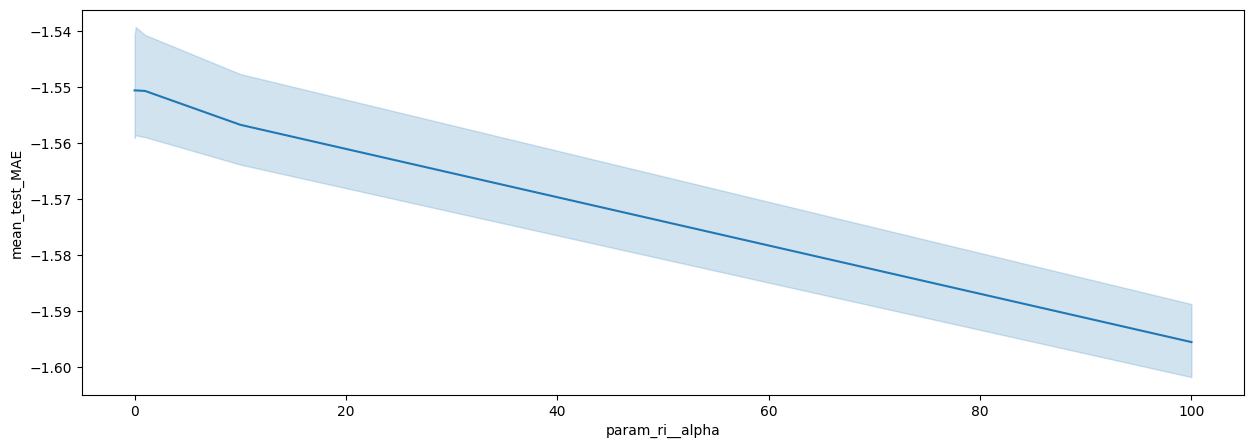

In [ ]:
fig, ax = plt.subplots(1, figsize=(15, 5))
sb.lineplot(data=ri_cv_results, x='param_ri__alpha', y='mean_test_MAE', ax=ax)

Ridge fungerer best på en lavere alpha-verdi. Jeg velger derfor å teste lavere verdier nærmere.

### Ridge; forbedret parametere

In [53]:
ri_params2 = {
    'ri__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 10]
}

In [54]:
ri_estimators2, ri_scores2, ri_cv_results2 = train(
    ri_pipe, 
    ri_params2,
    dataset_features,
    dataset_targets
    )
ri_scores2 = pd.DataFrame(ri_scores2)
ri_scores2.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.551118,-4.655655,-2.156874,0.551912
std,0.042347,0.287673,0.066604,0.023223
min,-1.610651,-5.027184,-2.242138,0.513076
25%,-1.571509,-4.823730,-2.196299,0.551780
50%,-1.549248,-4.688008,-2.165181,0.555374
75%,-1.521129,-4.377636,-2.092280,0.567842
max,-1.503054,-4.361718,-2.088473,0.571489


<Axes: xlabel='param_ri__alpha', ylabel='mean_test_MAE'>

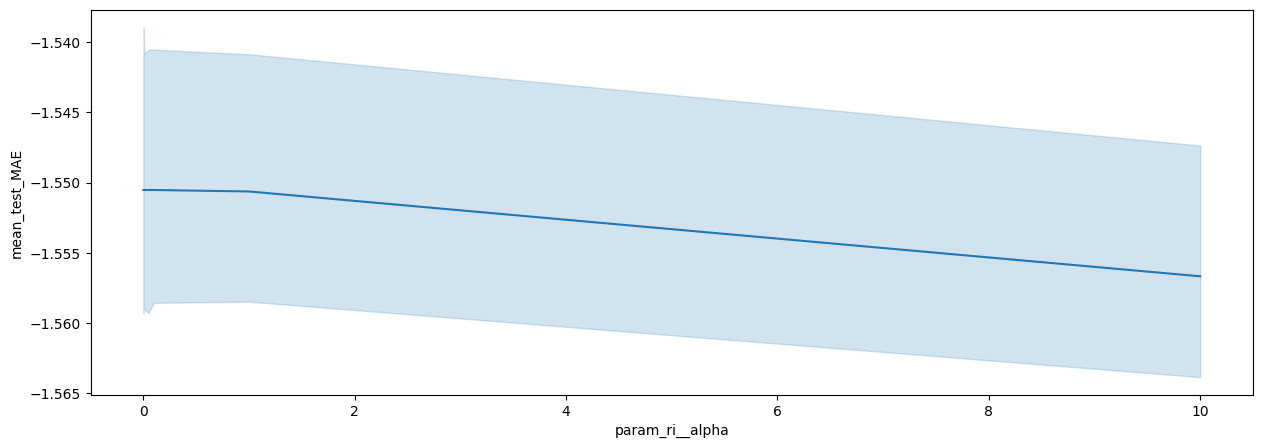

In [55]:
fig, ax = plt.subplots(1, figsize=(15, 5))
sb.lineplot(data=ri_cv_results2, x='param_ri__alpha', y='mean_test_MAE', ax=ax)

Her fikk jeg flatet ut grafen, men fikk ikke noen særlig forbedring på metrikkene. Dette betyr at videre tuning påvirker modellen svært lite. Variasjonen kommer hovedsakelig fra hvordan datasettet blir splittet. Metrikkene er også omtrent like som uten tuning.

In [56]:
columns = [
    'param_ri__alpha',
    'mean_test_MAE'
]

ri_cv_results2_sorted = (
    ri_cv_results2[columns].groupby(['param_ri__alpha'],
        as_index=False)['mean_test_MAE'].mean().sort_values('mean_test_MAE', ascending=False)
)

ri_cv_results2_sorted.head()

,param_ri__alpha,mean_test_MAE
3,0.050,-1.550528
4,0.100,-1.550528
2,0.010,-1.550528
1,0.005,-1.550528
0,0.001,-1.550529


Får relativt liten forbedring med hyperparametertuning. Fungerer i snitt best på alpha 0.05-0.005.

### Ridge; endelige parametere

In [58]:
ri_params_final = {
    'ri__alpha': [0.05]
}

In [63]:
ri_estimators_final, ri_scores_final, ri_cv_results_final = train(
    ri_pipe, 
    ri_params_final,
    dataset_features,
    dataset_targets
    )
ri_scores_final = pd.DataFrame(ri_scores_final)
ri_scores_final.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.551089,-4.658567,-2.157534,0.551630
std,0.043160,0.290460,0.067207,0.023599
min,-1.611865,-5.037773,-2.244498,0.512051
25%,-1.571522,-4.824411,-2.196454,0.551717
50%,-1.549219,-4.688171,-2.165219,0.555358
75%,-1.521143,-4.380638,-2.092997,0.567545
max,-1.501697,-4.361841,-2.088502,0.571476


### Random Forest Regressor

In [66]:
rf_params = {
    'regressor__rf__n_estimators': [100, 300],
    'regressor__rf__max_depth': [10, 20, 30],
    'regressor__rf__min_samples_split': [2, 5, 10],
    'regressor__rf__min_samples_leaf': [1, 3, 5, 10]
}

For random forest regressor har jeg valgt å tune 4 forskjellige hyperparametere som er blant de som oftest vil påvirke modellen mest. Jeg startet med å teste brede verdier.

n_estimators bestemmer hvor mange trær modellen skal lage. En lav verdi vil gjøre at treningen er raskere, men kan føre til at modellen ikke blir robust nok. En høyere verdi vil gjøre modellen mer stabil, men vil utvide treningstiden.

max_depth bestemmer hvor dypt et tre kan være. En lav verdi vil kunne gjøre modellen god generelt og senke sannsynligheten før overfitting, men kan føre til at den sliter med å fange opp mer komplekse mønstre. En høyere verdi vil kunne fa nge fler komplekse mønstre, men vil samtidig gi høyere sjans for overfitting.

min_samples_split bestemmer hvor mange antall samples det må være i en node for at den skal splitte seg. En lav verdi vil kunne gjøre at modellen enklere fanger opp fler små detaljer, men kan føre til at trærne blir for dype og det blir overfitting. En høyere verdi vil senke sannsynligheten for overfitting ettersom den ikke ser etter like komplekse mønstre, samtidig så kan det føre til at den overser mønstre dersom verdien blir for høy.

min_samples_leaf bestemmer hvor mange samples en bladnode minst må ha. En lav verdi vil kunne gjøre at den lærer seg detaljerte mønstre, men vil samtidig øke sjansen for overfitting. En høyere verdi gjør det mindre sannsynlig med overfitting, men kan samtidig føre til at den ikke finner nok mønstre og blir upresis.

In [67]:
rf_estimators, rf_scores, rf_cv_results = train(
    rf_pipe, 
    rf_params,
    dataset_features,
    dataset_targets
    )
rf_scores = pd.DataFrame(rf_scores)
rf_scores.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.455859,-4.435669,-2.105474,0.573156
std,0.040263,0.239767,0.057518,0.015651
min,-1.502023,-4.692479,-2.166213,0.561512
25%,-1.472363,-4.527112,-2.127701,0.563976
50%,-1.467455,-4.509888,-2.123650,0.567834
75%,-1.443109,-4.398921,-2.097361,0.572267
max,-1.394346,-4.049947,-2.012448,0.600191


<Axes: xlabel='param_regressor__rf__min_samples_leaf', ylabel='mean_test_MAE'>

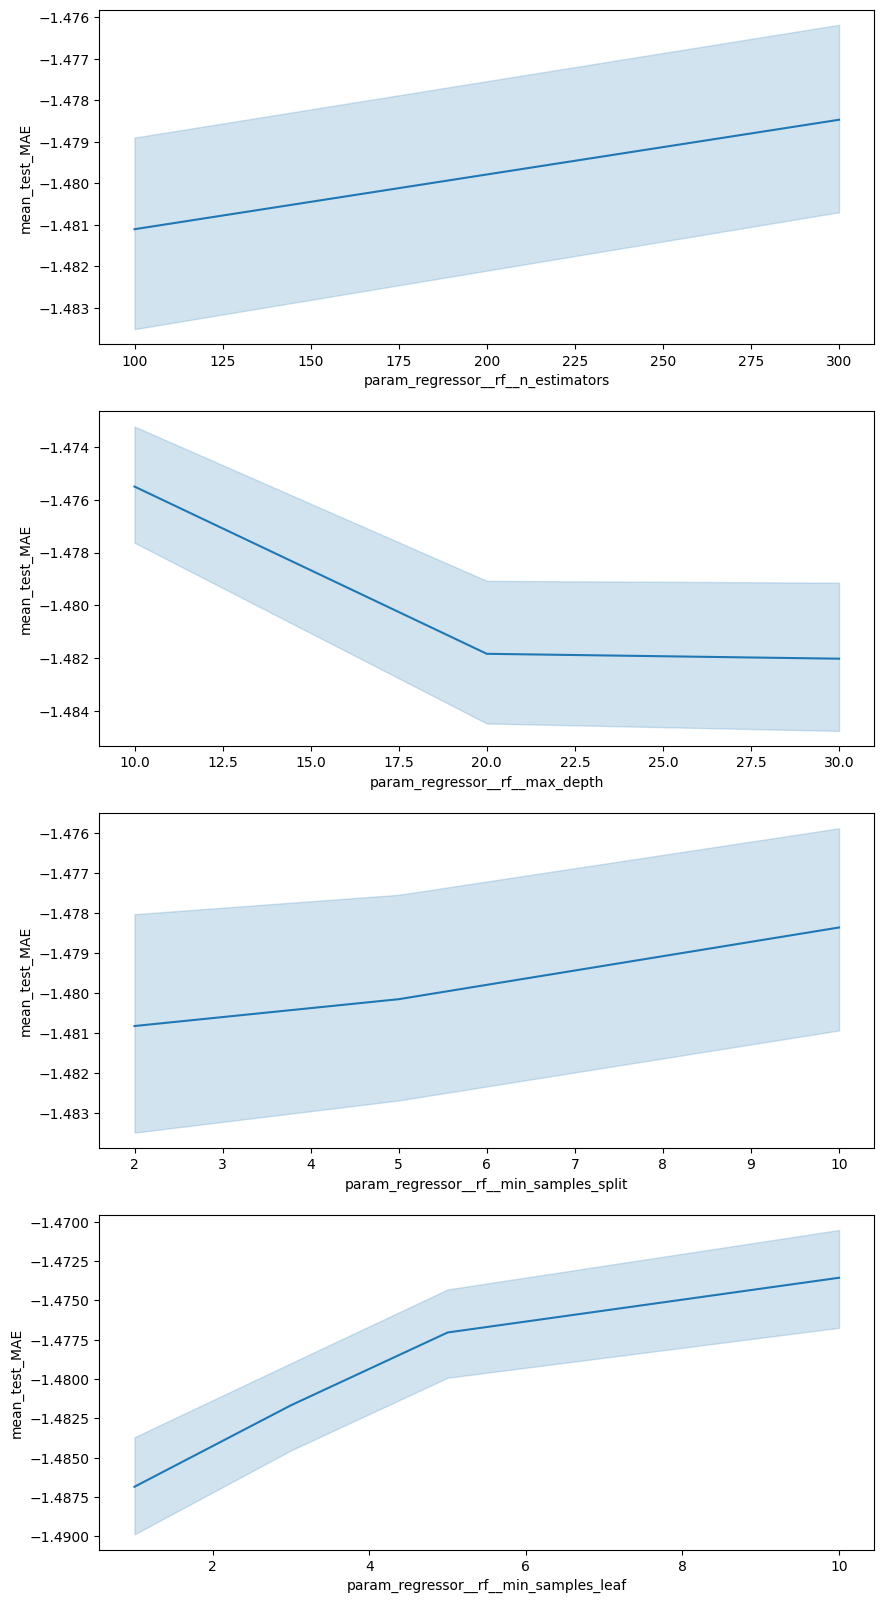

In [68]:
fig, ax = plt.subplots(4,1, figsize=(10, 20))
sb.lineplot(data=rf_cv_results, x='param_regressor__rf__n_estimators', y='mean_test_MAE', ax=ax[0])
sb.lineplot(data=rf_cv_results, x='param_regressor__rf__max_depth', y='mean_test_MAE', ax=ax[1])
sb.lineplot(data=rf_cv_results, x='param_regressor__rf__min_samples_split', y='mean_test_MAE', ax=ax[2])
sb.lineplot(data=rf_cv_results, x='param_regressor__rf__min_samples_leaf', y='mean_test_MAE', ax=ax[3])

En høyere verdi for n_estimators vil gjøre modellene i snitt litt bedre, noe som er forventet. Jeg velger derfor å teste et litt høyere antall. Trærne ser ut til å prestere bedre ved en lavere max_depth, og et høyere antall min_samples_split og min_samples_leaf.

### Random Forest; forbedret parametere

In [71]:
rf_params2 = {
    'regressor__rf__n_estimators': [300, 400],
    'regressor__rf__max_depth': [5, 8, 10, 15],
    'regressor__rf__min_samples_split': [8, 10, 15],
    'regressor__rf__min_samples_leaf': [5, 8, 10, 15]
}

In [72]:
rf_estimators2, rf_scores2, rf_cv_results2 = train(
    rf_pipe, 
    rf_params2,
    dataset_features,
    dataset_targets
    )
rf_scores2 = pd.DataFrame(rf_scores2)
rf_scores2.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.455584,-4.432617,-2.104725,0.573459
std,0.042058,0.244194,0.058628,0.016000
min,-1.505073,-4.691457,-2.165977,0.562149
25%,-1.472232,-4.520543,-2.126157,0.564071
50%,-1.465970,-4.516865,-2.125292,0.568147
75%,-1.442950,-4.395732,-2.096600,0.571606
max,-1.391696,-4.038490,-2.009600,0.601322


<Axes: xlabel='param_regressor__rf__min_samples_leaf', ylabel='mean_test_MAE'>

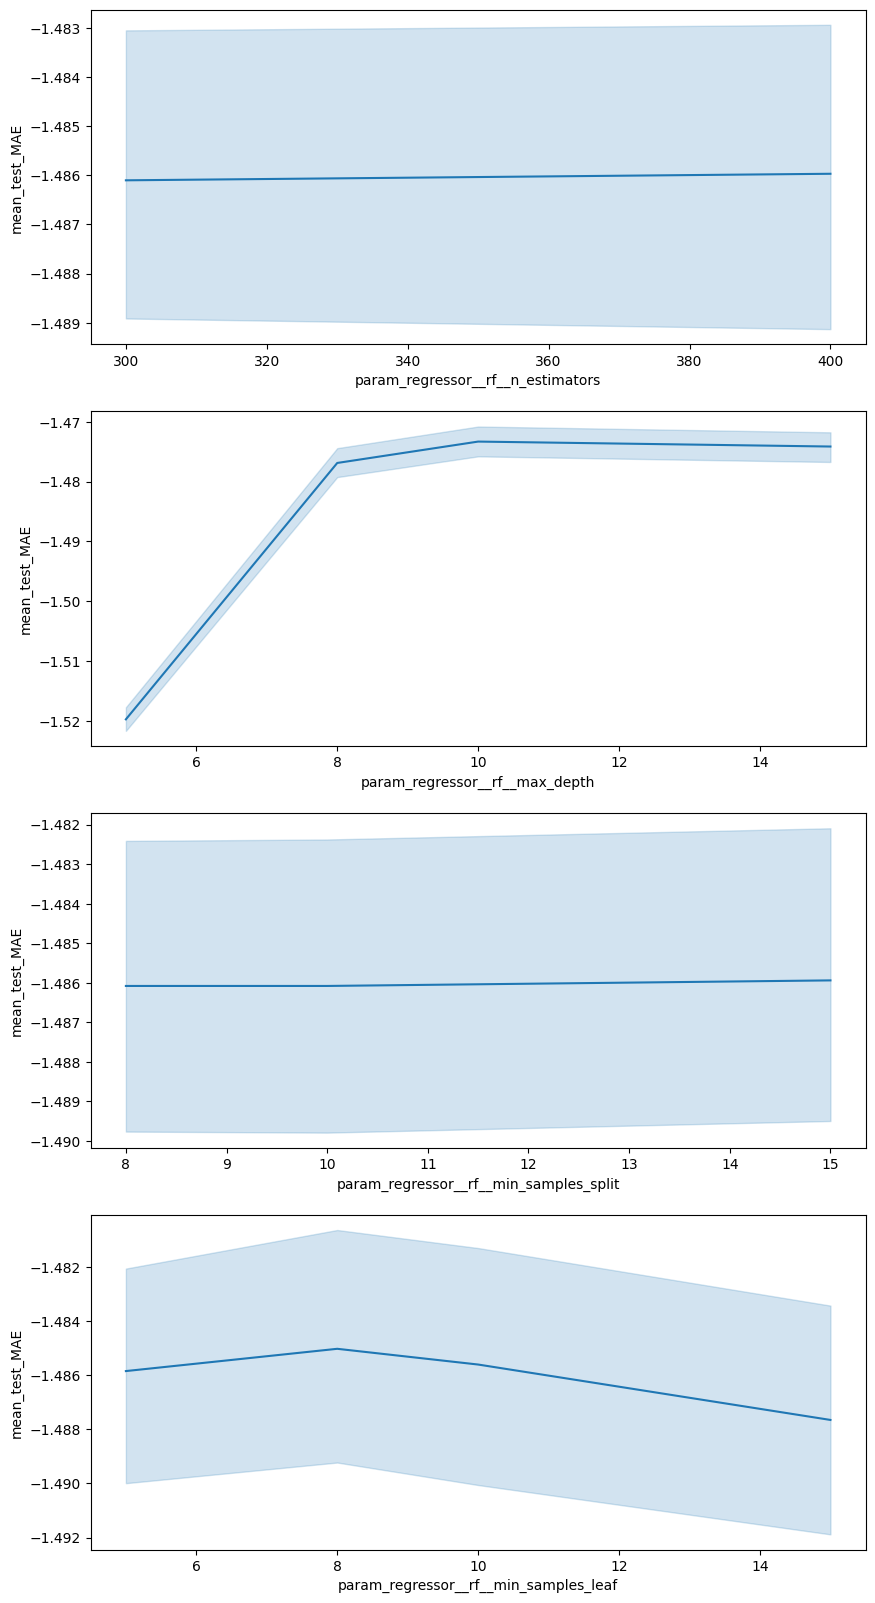

In [74]:
fig, ax = plt.subplots(4,1, figsize=(10, 20))
sb.lineplot(data=rf_cv_results2, x='param_regressor__rf__n_estimators', y='mean_test_MAE', ax=ax[0])
sb.lineplot(data=rf_cv_results2, x='param_regressor__rf__max_depth', y='mean_test_MAE', ax=ax[1])
sb.lineplot(data=rf_cv_results2, x='param_regressor__rf__min_samples_split', y='mean_test_MAE', ax=ax[2])
sb.lineplot(data=rf_cv_results2, x='param_regressor__rf__min_samples_leaf', y='mean_test_MAE', ax=ax[3])

Det er ingen synlig økning fra 300-400 n_estimators, så jeg velger å teste litt lavere verdier. Ellers ser det ut til å være optimalt med rundt 8 i max_depth, min_samples_split holder seg stabilt, og rundt 8 min_samples_leaf_.

### Random Forest; Forbedret parametere

In [77]:
rf_params3 = {
    'regressor__rf__n_estimators': [200, 300],
    'regressor__rf__max_depth': [8, 10, 12],
    'regressor__rf__min_samples_split': [10, 12, 15, 20],
    'regressor__rf__min_samples_leaf': [6, 8, 12]
}

In [78]:
rf_estimators3, rf_scores3, rf_cv_results3 = train(
    rf_pipe, 
    rf_params3,
    dataset_features,
    dataset_targets
    )
rf_scores3 = pd.DataFrame(rf_scores3)
rf_scores3.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.453969,-4.425375,-2.103023,0.574154
std,0.041168,0.240584,0.057772,0.015560
min,-1.501770,-4.685267,-2.164548,0.563365
25%,-1.471428,-4.507982,-2.123201,0.564646
50%,-1.464330,-4.507515,-2.123091,0.569042
75%,-1.440890,-4.386620,-2.094426,0.572492
max,-1.391429,-4.039491,-2.009848,0.601223


<Axes: xlabel='param_regressor__rf__min_samples_leaf', ylabel='mean_test_MAE'>

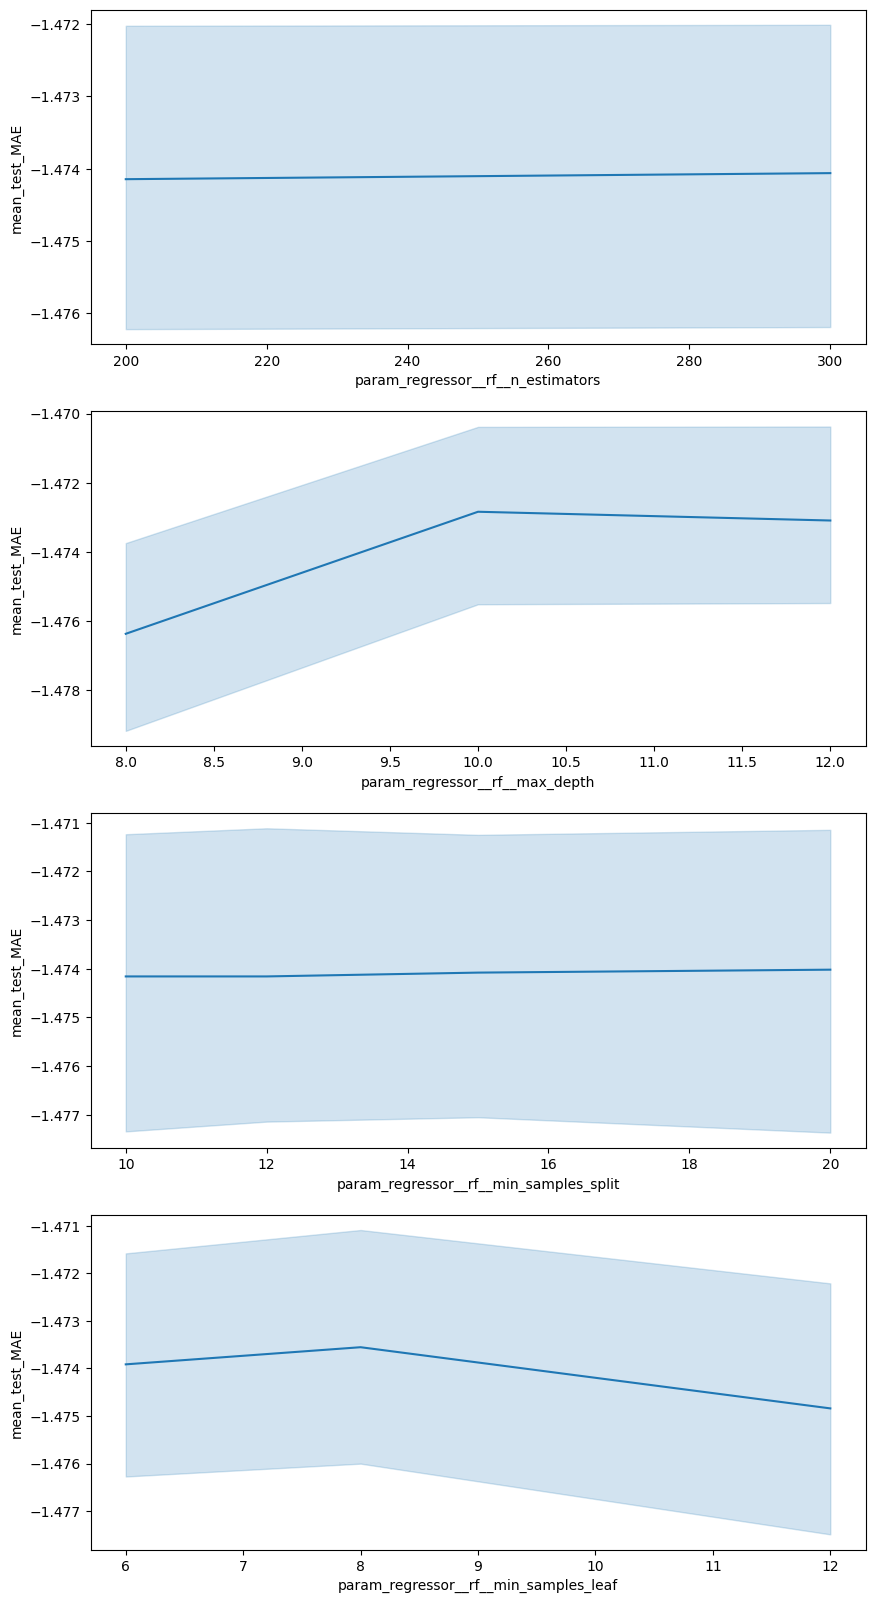

In [79]:
fig, ax = plt.subplots(4,1, figsize=(10, 20))
sb.lineplot(data=rf_cv_results3, x='param_regressor__rf__n_estimators', y='mean_test_MAE', ax=ax[0])
sb.lineplot(data=rf_cv_results3, x='param_regressor__rf__max_depth', y='mean_test_MAE', ax=ax[1])
sb.lineplot(data=rf_cv_results3, x='param_regressor__rf__min_samples_split', y='mean_test_MAE', ax=ax[2])
sb.lineplot(data=rf_cv_results3, x='param_regressor__rf__min_samples_leaf', y='mean_test_MAE', ax=ax[3])

Grafene viser at jeg har funnet de beste parameterene.

In [80]:
columns = [
    'param_regressor__rf__n_estimators',
    'param_regressor__rf__max_depth',
    'param_regressor__rf__min_samples_split',
    'param_regressor__rf__min_samples_leaf',
    'mean_test_MAE'
]

rf_cv_results3_sorted = (
    rf_cv_results3[columns].groupby(['param_regressor__rf__n_estimators', 'param_regressor__rf__max_depth', 'param_regressor__rf__min_samples_split', 'param_regressor__rf__min_samples_leaf',],
        as_index=False)['mean_test_MAE'].mean().sort_values('mean_test_MAE', ascending=False)
)

rf_cv_results3_sorted.head()

,param_regressor__rf__n_estimators,param_regressor__rf__max_depth,param_regressor__rf__min_samples_split,param_regressor__rf__min_samples_leaf,mean_test_MAE
49,300,10,10,8,-1.472173
52,300,10,12,8,-1.472173
55,300,10,15,8,-1.472173
57,300,10,20,6,-1.472233
58,300,10,20,8,-1.472274


N_estimators er best på 300, max_depth er best på 10, min_samples_split på 10-15 og min_samples_leaf på 8. 

### Random Forest; endelige parametere

In [81]:
rf_params_final = {
    'regressor__rf__n_estimators': [300],
    'regressor__rf__max_depth': [10],
    'regressor__rf__min_samples_split': [10],
    'regressor__rf__min_samples_leaf': [8]
}

In [82]:
rf_estimators_final, rf_scores_final, rf_cv_results_final = train(
    rf_pipe, 
    rf_params_final,
    dataset_features,
    dataset_targets
    )
rf_scores_final = pd.DataFrame(rf_scores_final)
rf_scores_final.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.453944,-4.427046,-2.103429,0.573978
std,0.041333,0.238454,0.057353,0.015798
min,-1.501447,-4.669321,-2.160861,0.563783
25%,-1.467945,-4.516865,-2.125292,0.566128
50%,-1.465970,-4.503669,-2.122185,0.566600
75%,-1.444866,-4.411478,-2.100352,0.571606
max,-1.389491,-4.033900,-2.008457,0.601775


### Gradient Boosting Regressor

In [83]:
gb_params = {
    'regressor__gb__n_estimators': [100, 300],
    'regressor__gb__learning_rate': [0.05, 0.1, 0.2],
    'regressor__gb__max_depth': [2, 3, 5],
    'regressor__gb__min_samples_split': [2, 5, 10],
    'regressor__gb__min_samples_leaf': [1, 3, 5, 10]
}

Jeg har valgt å tune 5 hyperparametere for Gradient Boosting Regressor med litt brede verdier som et utgangspunkt her også. Jeg har forsøkt å velge de mest relevante hyperparameterene for å kunne få best mulige resultater uten at kjøretiden blir for ekstrem.

N_estimators er antall trær som bygges. En lav verdi vil gi raskere kjøretid, men kan føre til at modellen underfitter dersom den ikke lærer nok av trærne. En høyere verdi vil gjøre modellen mer nøyaktig, men vil gjøre treningen tregere, samt kan føre til overfitting dersom learning rate er for høy.

Learning_rate er hvor mye hvert tre påvirker modellen. En lav verdi vil senke sannsynligheten for overfitting ettersom treningen blir mer stabil, men vil da trenge fler trær og kan bli tregere. En høyere verdi vil gjøre at modellen lærer raskere og det behøves færre trær, men det vil også bli mer sannsynlig med overfitting.

Max_depth er maksdybden et tre kan ha. En lavere verdi vil senke verdien for overfitting ettersom trærne blir mer generelle, men kan samtidig føre til at modellen underfitter om den ikke finner komplekse nok mønstre. En høyere verdi vil kunne la modellen finne fler komplekse mønstre, men kan fort føre til overfitting. Ettersom Gradient Boosting Regressor skal bygge mange svake trær for å lage en modell så er det hensiktsmessig å teste lavere verdier her enn for Random Forest Regressor.

Min_samples_split er hvor mange samples det må være i en node for at den skal splitte seg. En lav verdi vil kunne gjøre at modellen enklere fanger opp fler små detaljer, men kan føre til at trærne blir for dype og det blir overfitting. En høyere verdi vil senke sannsynligheten for overfitting ettersom den ikke ser etter like komplekse mønstre, samtidig så kan det føre til at den overser mønstre dersom verdien blir for høy.

Min_samples_leaf er hvor mange observasjoner som det minst skal være i en bladnode. En lav verdi vil gjøre at trærne kan finne mer komplekse mønstre, men vil øke sannsynligheten for overfitting. En høyere verdi vil redusere sannsynligheten for overfitting og trærne blir mer generelle, men kan føre til at modellen ikke finner nok detaljer.

In [84]:
gb_estimators, gb_scores, gb_cv_results = train(
    gb_pipe, 
    gb_params,
    dataset_features,
    dataset_targets
    )
gb_scores = pd.DataFrame(gb_scores)
gb_scores.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.462526,-4.456267,-2.110728,0.571023
std,0.037252,0.155159,0.036963,0.009471
min,-1.512064,-4.604275,-2.145757,0.557764
25%,-1.483313,-4.565814,-2.136776,0.567688
50%,-1.464602,-4.494940,-2.120127,0.572172
75%,-1.430771,-4.400399,-2.097713,0.573685
max,-1.421880,-4.215905,-2.053267,0.583808


<Axes: xlabel='param_regressor__gb__min_samples_leaf', ylabel='mean_test_MAE'>

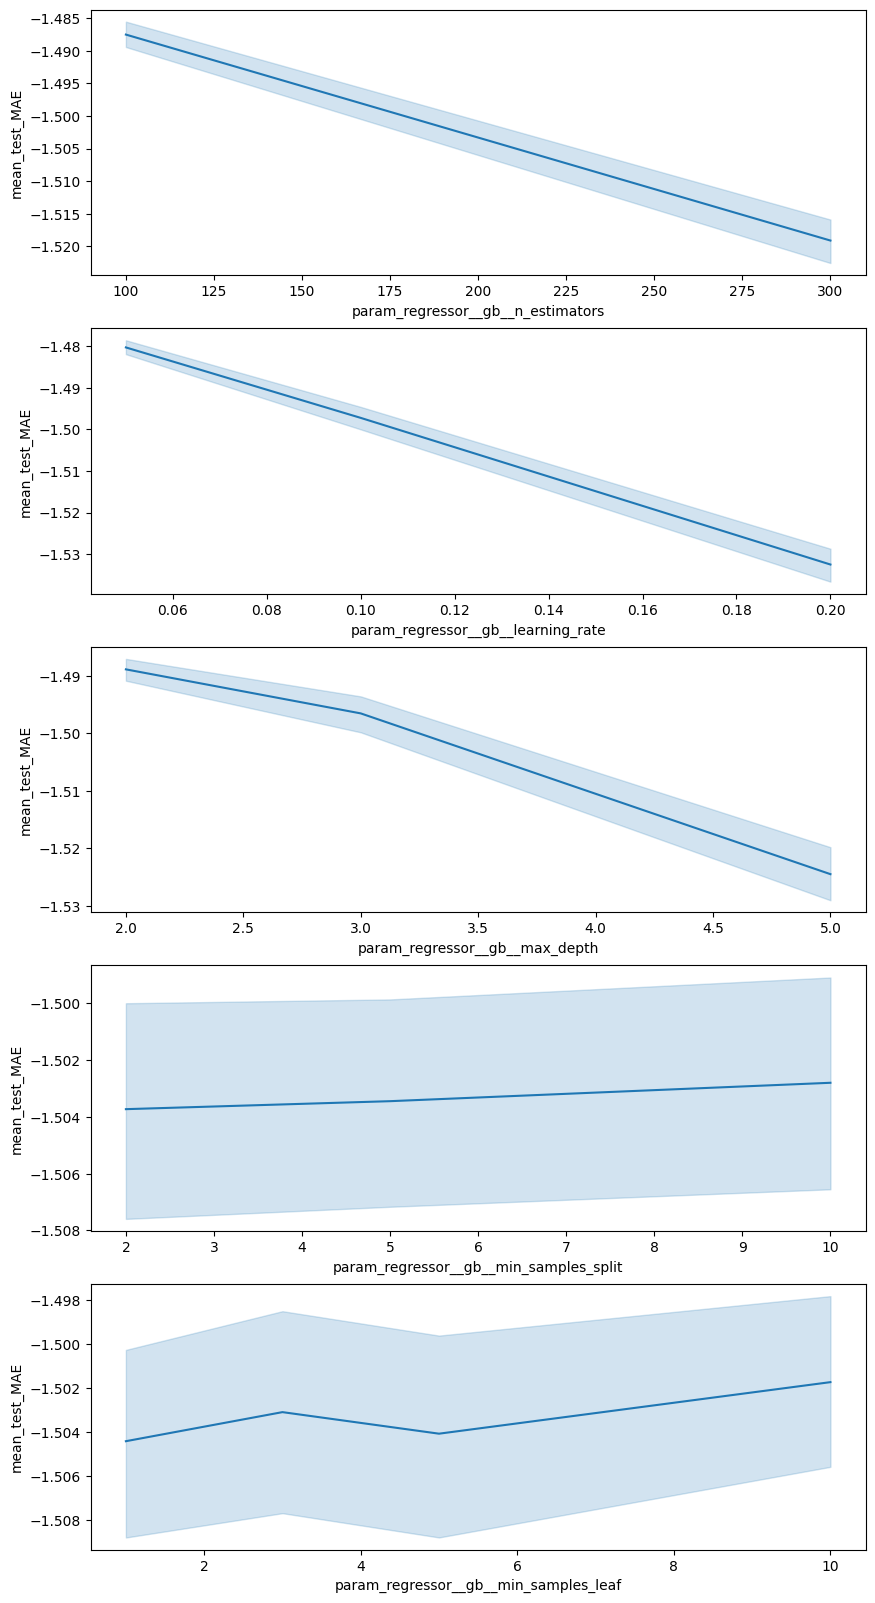

In [86]:
fig, ax = plt.subplots(5,1, figsize=(10, 20))
sb.lineplot(data=gb_cv_results, x='param_regressor__gb__n_estimators', y='mean_test_MAE', ax=ax[0])
sb.lineplot(data=gb_cv_results, x='param_regressor__gb__learning_rate', y='mean_test_MAE', ax=ax[1])
sb.lineplot(data=gb_cv_results, x='param_regressor__gb__max_depth', y='mean_test_MAE', ax=ax[2])
sb.lineplot(data=gb_cv_results, x='param_regressor__gb__min_samples_split', y='mean_test_MAE', ax=ax[3])
sb.lineplot(data=gb_cv_results, x='param_regressor__gb__min_samples_leaf', y='mean_test_MAE', ax=ax[4])

N_estimators fungerer bedre med et lavere antall, mulig at en for høy learning_rate også påvirker dette. Learning_rate ser ut til å fungere bedre på en lavere verdi. Max_depth er bedre på en lav verdi. Min_samples_split holder seg ganske jevn, øker minimalt ved en høyere verdi. Min_samples_leaf ser ut til å fungere bedre på en høyere verdi.

### Gradient Boosting; forbedret parametere

In [109]:
gb_params2 = {
    'regressor__gb__n_estimators': [50, 100, 200],
    'regressor__gb__learning_rate': [0.01, 0.05, 0.1],
    'regressor__gb__max_depth': [2, 3, 4],
    'regressor__gb__min_samples_split': [5, 10, 15],
    'regressor__gb__min_samples_leaf': [8, 10, 15]
}

In [110]:
gb_estimators2, gb_scores2, gb_cv_results2 = train(
    gb_pipe, 
    gb_params2,
    dataset_features,
    dataset_targets
    )
gb_scores2 = pd.DataFrame(gb_scores2)
gb_scores2.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.452350,-4.372396,-2.090841,0.578973
std,0.039807,0.129572,0.031222,0.012568
min,-1.510969,-4.496106,-2.120402,0.564515
25%,-1.470936,-4.408099,-2.099547,0.566932
50%,-1.445769,-4.403250,-2.098392,0.582423
75%,-1.420166,-4.402806,-2.098287,0.590144
max,-1.413910,-4.151716,-2.037576,0.590851


<Axes: xlabel='param_regressor__gb__min_samples_leaf', ylabel='mean_test_MAE'>

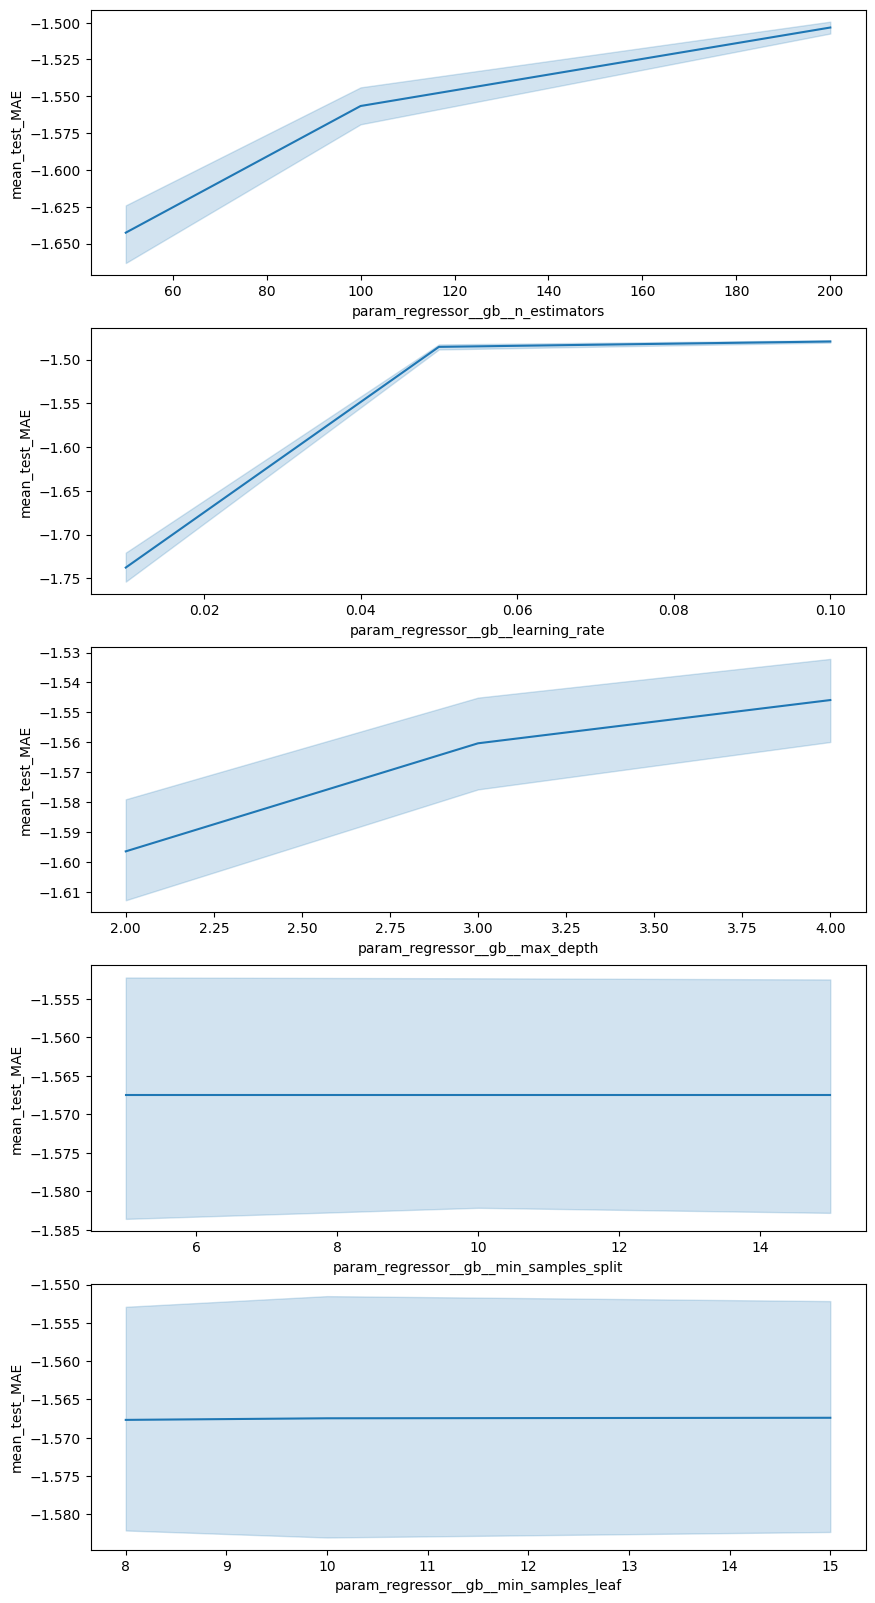

In [89]:
fig, ax = plt.subplots(5,1, figsize=(10, 20))
sb.lineplot(data=gb_cv_results2, x='param_regressor__gb__n_estimators', y='mean_test_MAE', ax=ax[0])
sb.lineplot(data=gb_cv_results2, x='param_regressor__gb__learning_rate', y='mean_test_MAE', ax=ax[1])
sb.lineplot(data=gb_cv_results2, x='param_regressor__gb__max_depth', y='mean_test_MAE', ax=ax[2])
sb.lineplot(data=gb_cv_results2, x='param_regressor__gb__min_samples_split', y='mean_test_MAE', ax=ax[3])
sb.lineplot(data=gb_cv_results2, x='param_regressor__gb__min_samples_leaf', y='mean_test_MAE', ax=ax[4])

N_estimators, learning_rate og max_depth ser ut til å stige litt ved en høyere verdi. Min_samples_split og min_samples_leaf holder seg relativt stabilt.

### Gradient Boosting; forbedret parametere

In [91]:
gb_params3 = {
    'regressor__gb__n_estimators': [100, 150, 200, 250],
    'regressor__gb__learning_rate': [0.01, 0.05, 0.1, 0.15],
    'regressor__gb__max_depth': [2, 3, 4, 5],
    'regressor__gb__min_samples_split': [5, 10, 15],
    'regressor__gb__min_samples_leaf': [15, 20, 25]
}

In [92]:
gb_estimators3, gb_scores3, gb_cv_results3 = train(
    gb_pipe, 
    gb_params3,
    dataset_features,
    dataset_targets
    )
gb_scores3 = pd.DataFrame(gb_scores3)
gb_scores3.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.451666,-4.358071,-2.087421,0.580361
std,0.039097,0.126691,0.030478,0.011889
min,-1.510969,-4.496106,-2.120402,0.564515
25%,-1.463926,-4.430866,-2.104962,0.570603
50%,-1.449738,-4.370736,-2.090630,0.588285
75%,-1.419903,-4.332096,-2.081369,0.589130
max,-1.413792,-4.160551,-2.039743,0.589272


<Axes: xlabel='param_regressor__gb__min_samples_leaf', ylabel='mean_test_MAE'>

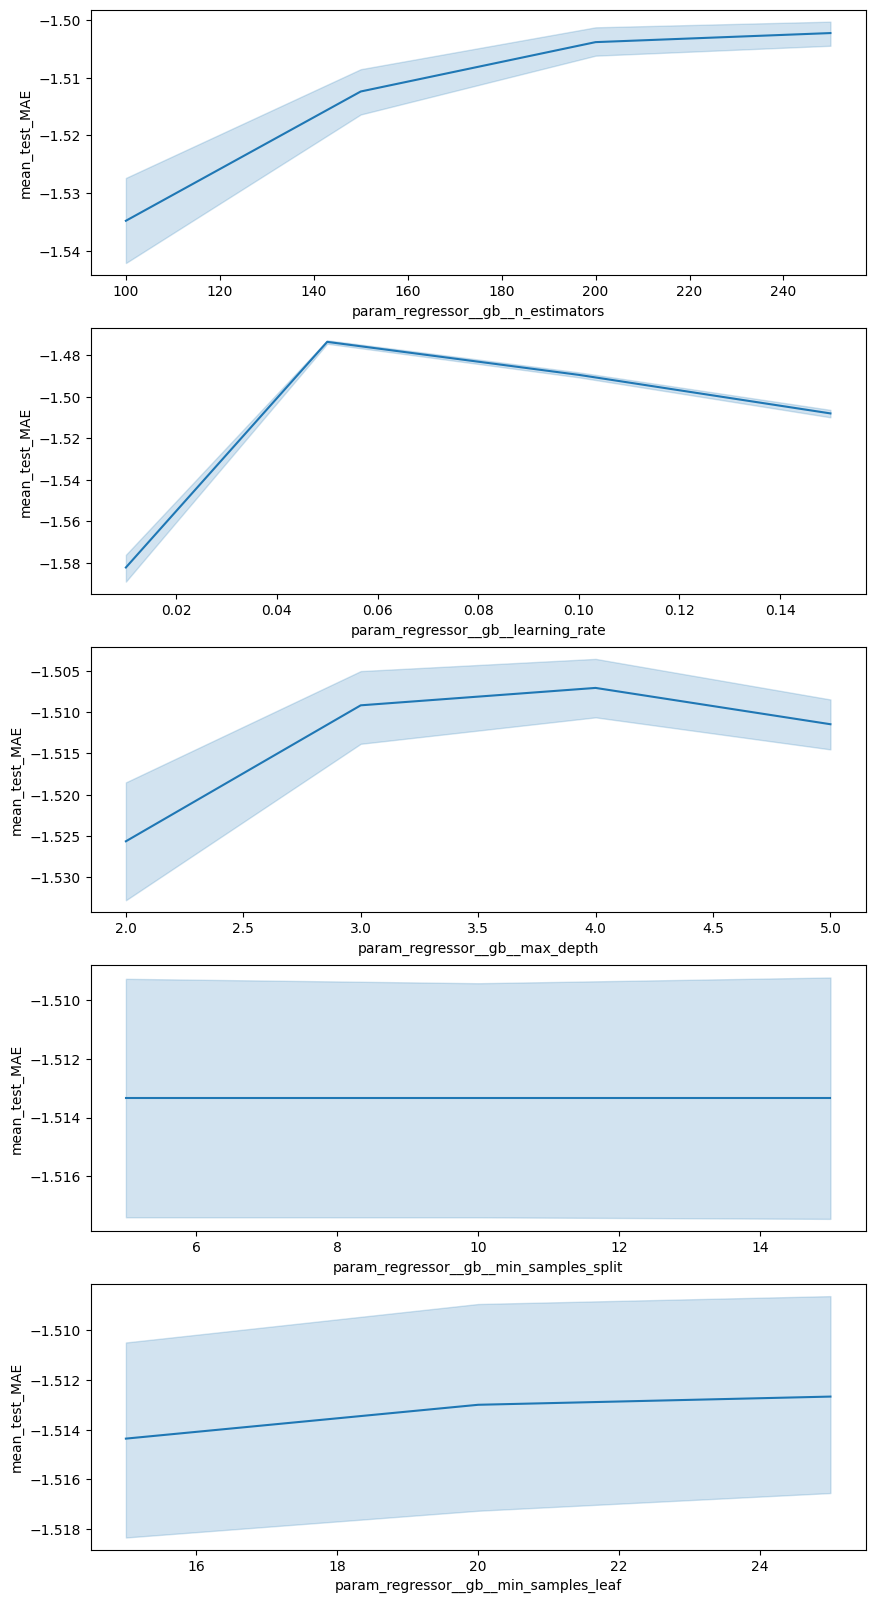

In [93]:
fig, ax = plt.subplots(5,1, figsize=(10, 20))
sb.lineplot(data=gb_cv_results3, x='param_regressor__gb__n_estimators', y='mean_test_MAE', ax=ax[0])
sb.lineplot(data=gb_cv_results3, x='param_regressor__gb__learning_rate', y='mean_test_MAE', ax=ax[1])
sb.lineplot(data=gb_cv_results3, x='param_regressor__gb__max_depth', y='mean_test_MAE', ax=ax[2])
sb.lineplot(data=gb_cv_results3, x='param_regressor__gb__min_samples_split', y='mean_test_MAE', ax=ax[3])
sb.lineplot(data=gb_cv_results3, x='param_regressor__gb__min_samples_leaf', y='mean_test_MAE', ax=ax[4])

Grafene viser at jeg har funnet de omtrent beste hyperparameterne.

Jeg har nå funnet omtrent de beste parameterene.

In [94]:
columns = [
    'param_regressor__gb__n_estimators',
    'param_regressor__gb__learning_rate',
    'param_regressor__gb__max_depth',
    'param_regressor__gb__min_samples_split',
    'param_regressor__gb__min_samples_leaf',
    'mean_test_MAE'
]

gb_cv_results3_sorted = (
    gb_cv_results3[columns].groupby(['param_regressor__gb__n_estimators', 'param_regressor__gb__learning_rate', 'param_regressor__gb__max_depth', 'param_regressor__gb__min_samples_split', 'param_regressor__gb__min_samples_leaf',],
        as_index=False)['mean_test_MAE'].mean().sort_values('mean_test_MAE', ascending=False)
)

gb_cv_results3_sorted.head()

,param_regressor__gb__n_estimators,param_regressor__gb__learning_rate,param_regressor__gb__max_depth,param_regressor__gb__min_samples_split,param_regressor__gb__min_samples_leaf,mean_test_MAE
54,100,0.05,4,5,15,-1.462033
60,100,0.05,4,15,15,-1.462033
57,100,0.05,4,10,15,-1.462033
59,100,0.05,4,10,25,-1.462692
62,100,0.05,4,15,25,-1.462692


De beste parameterene er n_estimators på 100, learning_rate på 0.05, max_depth på 4, min_samples_split på 5-15 og min_samples_leaf på 15.

### Gradient Boosting; endelige parametere

In [95]:
gb_params_final = {
    'regressor__gb__n_estimators': [100],
    'regressor__gb__learning_rate': [0.05],
    'regressor__gb__max_depth': [4],
    'regressor__gb__min_samples_split': [5],
    'regressor__gb__min_samples_leaf': [15]
}

In [96]:
gb_estimators_final, gb_scores_final, gb_cv_results_final = train(
    gb_pipe, 
    gb_params_final,
    dataset_features,
    dataset_targets
    )
gb_scores_final = pd.DataFrame(gb_scores_final)
gb_scores_final.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.452128,-4.355609,-2.086820,0.580602
std,0.038993,0.130622,0.031467,0.012148
min,-1.510969,-4.496106,-2.120402,0.564515
25%,-1.465046,-4.418775,-2.102088,0.570603
50%,-1.450149,-4.370736,-2.090630,0.587707
75%,-1.419903,-4.347099,-2.084970,0.589409
max,-1.414571,-4.145329,-2.036008,0.590775


### MLP Regressor

In [113]:
mlp_params = {
    'mlp__hidden_layer_sizes': [(8,), (16,), (8,4), (16, 8), (8, 4, 2), (16, 8, 4)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam'],
    'mlp__alpha': [0.00001, 0.0001, 0.001, 0.01],
    'mlp__learning_rate_init': [0.0005, 0.001, 0.005],
}

For MLP har jeg valgt 4 hyperparametere å tune, som bør være de som skal påvirke modellene mest. Jeg har startet med å teste brede verdier.

Hidden_layes_sizes bestemmer arkitekturen til det nevrale nettverket, nemlig hvor mange skjulte lag det skal ha og hvor mange nevroner hver lag har. Et lavt antall nevroner eller lag vil gjøre treningene raskere og minke sannsynligheten for overfitting, men kan samtidig føre til at modellen blir for enkel og presterer dårlig. Et høyere antall nevroner eller lag vil kunne få modellen til å fange opp mer komplekse mønstre, men kan føre til overfitting og vil utvide treningstiden.

Activation er aktiveringsfunksjonen som brukes i de skjulte lagene. Relu er standard og skal som regel fungere best, men på enkelte datasett kan tanh være bedre.

Alpha er verdien som bestemmer hvor mye modellen skal straffer store koeffisienter. En lav alpha vil kunne gjøre at modellen finner mer detaljer i dataen, men kan samtidig føre til overfitting. En høyere alpha vil minke sjansen for overfitting og gjøre modellen mer robust, men kan samtidig føre til at modellen ikke finner nok mønstre i dataen.

learning_rate_init bestemmer hvor mye modellen modellen justerer seg dersom vektene oppdaterer seg under trening. En lav verdi vil gjøre treningen mer stabil ettersom den er mer presis, men kan samtidig føre til en lang treningstid. En høyere verdi vil gjøre treningen raskere, men kan føre til at resultatene blir ustabile.

Jeg hadde egentlig også tenkt til å teste flere solvers, slik som lbfgs, men da trengte modellen svært mage iterasjoner, og treningen tok  svært lang tid.

In [103]:
mlp_estimators, mlp_scores, mlp_cv_results = train(
    mlp_pipe, 
    mlp_params,
    dataset_features,
    dataset_targets
    )
mlp_scores = pd.DataFrame(mlp_scores) 
mlp_scores.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.452657,-4.296777,-2.072634,0.586250
std,0.032994,0.143554,0.034763,0.014111
min,-1.499113,-4.475735,-2.115593,0.566489
25%,-1.455874,-4.328549,-2.080517,0.576378
50%,-1.454001,-4.311946,-2.076523,0.592879
75%,-1.448159,-4.292568,-2.071851,0.597709
max,-1.406139,-4.075085,-2.018684,0.597792


<Axes: xlabel='param_mlp__learning_rate_init', ylabel='mean_test_MAE'>

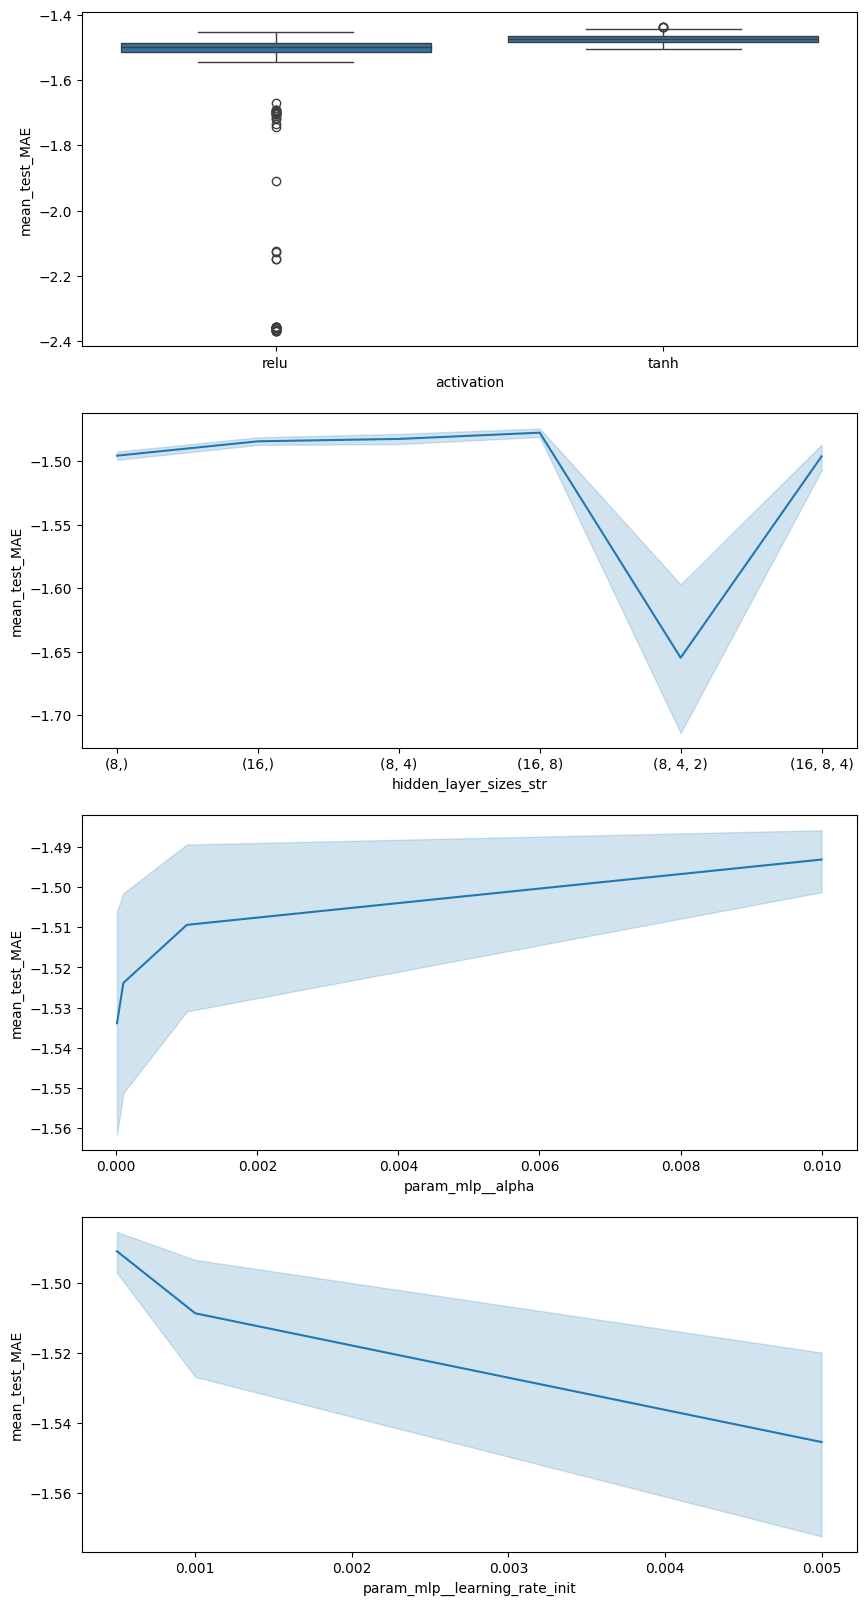

In [104]:
mlp_cv_results_plot = mlp_cv_results.copy()
mlp_cv_results_plot['activation'] = mlp_cv_results_plot['param_mlp__activation'].fillna('None').astype(str)

mlp_cv_results_plot['hidden_layer_sizes_str'] = (mlp_cv_results_plot['param_mlp__hidden_layer_sizes'].astype(str))

fig, ax = plt.subplots(4,1, figsize=(10, 20))
sb.boxplot(data=mlp_cv_results_plot, x='activation', y='mean_test_MAE', ax=ax[0])
sb.lineplot(data=mlp_cv_results_plot, x='hidden_layer_sizes_str', y='mean_test_MAE', ax=ax[1])
sb.lineplot(data=mlp_cv_results_plot, x='param_mlp__alpha', y='mean_test_MAE', ax=ax[2])
sb.lineplot(data=mlp_cv_results_plot, x='param_mlp__learning_rate_init', y='mean_test_MAE', ax=ax[3])

Fra grafene ser det ut som at tanh presterer litt bedre enn relu, hidden layer_sizes ser best ut med ett eller to mindre lag, eventuelt 4 større, alpha ser ut til å fungere best på høyere verdier, og learning_rate på lavere verdi.

### MLP; forbedret parametere

In [114]:
mlp_params2 = {
    'mlp__hidden_layer_sizes': [(4,), (16,), (16, 8), (32, 16), (16, 8, 4), (32, 16, 8)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam'],
    'mlp__alpha': [0.001, 0.01, 0.02],
    'mlp__learning_rate_init': [0.0001, 0.0005, 0.001],
}

In [115]:
mlp_estimators2, mlp_scores2, mlp_cv_results2 = train(
    mlp_pipe, 
    mlp_params2,
    dataset_features,
    dataset_targets
    )
mlp_scores2 = pd.DataFrame(mlp_scores2) 
mlp_scores2.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.451008,-4.263389,-2.064583,0.589456
std,0.034909,0.137093,0.033302,0.013777
min,-1.506219,-4.424678,-2.103492,0.571434
25%,-1.456008,-4.329228,-2.080680,0.577848
50%,-1.440946,-4.296982,-2.072916,0.597729
75%,-1.440809,-4.202715,-2.050052,0.598869
max,-1.411060,-4.063340,-2.015773,0.601401


<Axes: xlabel='param_mlp__learning_rate_init', ylabel='mean_test_MAE'>

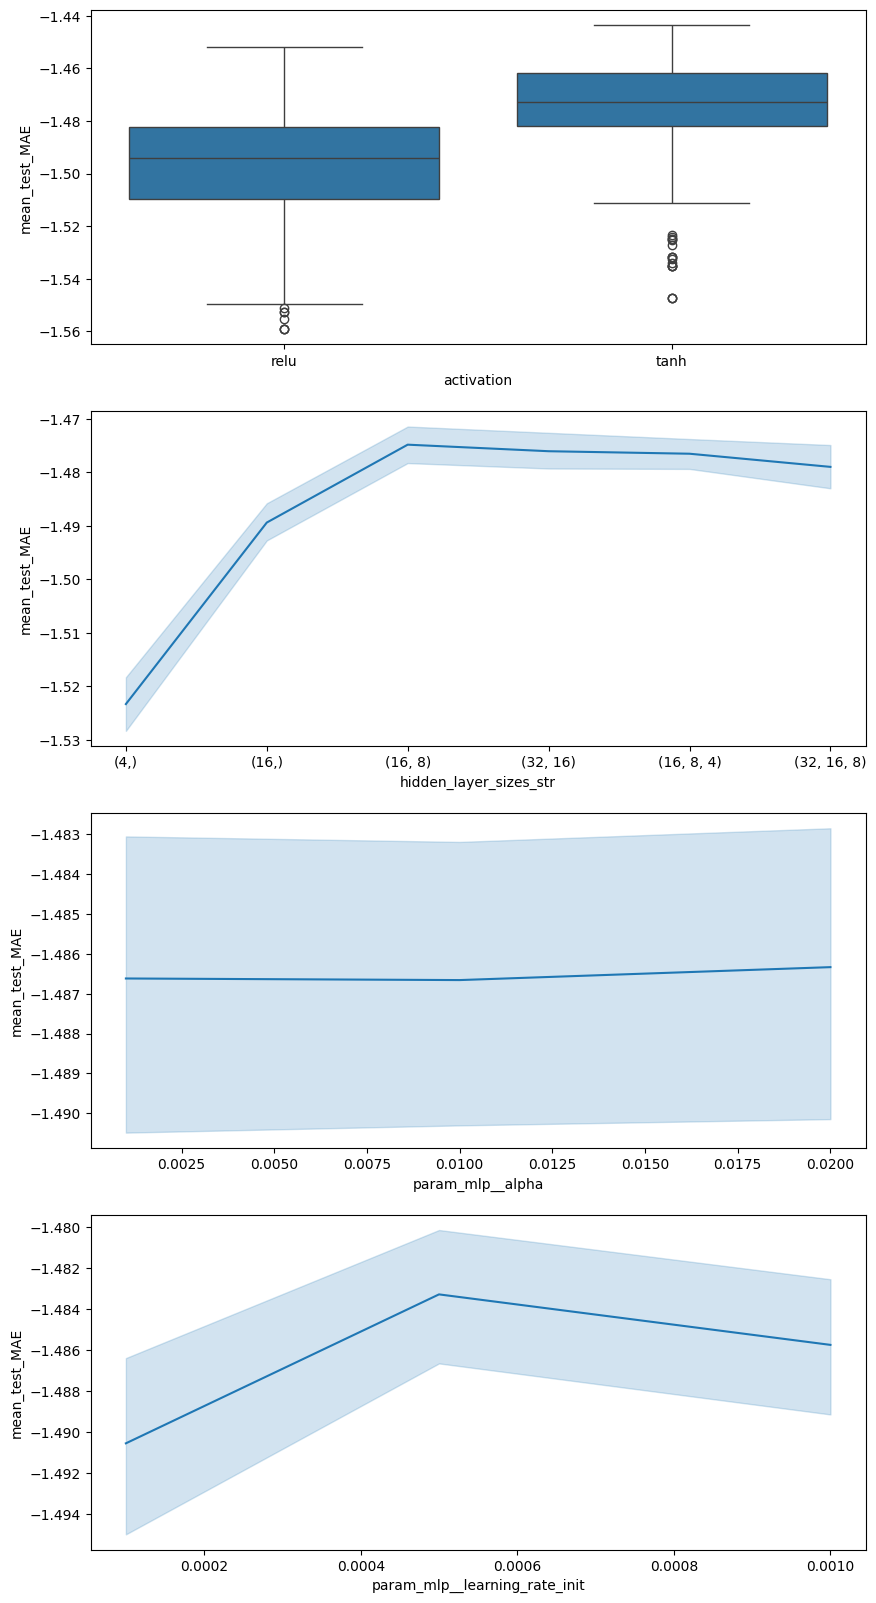

In [116]:
mlp_cv_results_plot2 = mlp_cv_results2.copy()
mlp_cv_results_plot2['activation'] = mlp_cv_results_plot2['param_mlp__activation'].fillna('None').astype(str)

mlp_cv_results_plot2['hidden_layer_sizes_str'] = (mlp_cv_results_plot2['param_mlp__hidden_layer_sizes'].astype(str))

fig, ax = plt.subplots(4,1, figsize=(10, 20))
sb.boxplot(data=mlp_cv_results_plot2, x='activation', y='mean_test_MAE', ax=ax[0])
sb.lineplot(data=mlp_cv_results_plot2, x='hidden_layer_sizes_str', y='mean_test_MAE', ax=ax[1])
sb.lineplot(data=mlp_cv_results_plot2, x='param_mlp__alpha', y='mean_test_MAE', ax=ax[2])
sb.lineplot(data=mlp_cv_results_plot2, x='param_mlp__learning_rate_init', y='mean_test_MAE', ax=ax[3])

Grafene viser at jeg har funnet de beste parameterene.

In [117]:
columns = [
    'param_mlp__hidden_layer_sizes',
    'param_mlp__activation',
    'param_mlp__alpha',
    'param_mlp__learning_rate_init',
    'mean_test_MAE'
]

mlp_cv_results2_sorted = (
    mlp_cv_results2[columns].groupby(['param_mlp__hidden_layer_sizes', 'param_mlp__activation', 'param_mlp__alpha', 'param_mlp__learning_rate_init'],
        as_index=False)['mean_test_MAE'].mean().sort_values('mean_test_MAE', ascending=False)
)

mlp_cv_results2_sorted.head()

,param_mlp__hidden_layer_sizes,param_mlp__activation,param_mlp__alpha,param_mlp__learning_rate_init,mean_test_MAE
52,"(16, 8)",tanh,0.020,0.0005,-1.461023
46,"(16, 8)",tanh,0.001,0.0005,-1.461120
49,"(16, 8)",tanh,0.010,0.0005,-1.461203
99,"(32, 16, 8)",tanh,0.001,0.0001,-1.461294
105,"(32, 16, 8)",tanh,0.020,0.0001,-1.461448


De beste parameterene er to lag med 16 og 8 nevroner, tanh, 0.02 i alpha-verdi og 0.0005 i learning rate.

### MLP; endelige parametere

In [118]:
mlp_params_final = {
    'mlp__hidden_layer_sizes': [(16,8)],
    'mlp__activation': ['tanh'],
    'mlp__solver': ['adam'],
    'mlp__alpha': [0.02],
    'mlp__learning_rate_init': [0.0005]
}

In [119]:
mlp_estimators_final, mlp_scores_final, mlp_cv_results_final = train(
    mlp_pipe, 
    mlp_params_final,
    dataset_features,
    dataset_targets
    )
mlp_scores_final = pd.DataFrame(mlp_scores_final) 
mlp_scores_final.describe()

,MAE,MSE,RMSE,R2
count,5.000000,5.000000,5.000000,5.000000
mean,-1.451114,-4.261270,-2.064021,0.589692
std,0.035015,0.151211,0.036858,0.014053
min,-1.506219,-4.424678,-2.103492,0.571434
25%,-1.456008,-4.329228,-2.080680,0.577936
50%,-1.441676,-4.296091,-2.072701,0.597729
75%,-1.441265,-4.236568,-2.058293,0.598190
max,-1.410402,-4.019785,-2.004940,0.603169


### Keras Regressor

## Sammenligning av resultater og konklusjon

In [120]:
training_results = pd.DataFrame({
    'Metric' : ['MAE', 'MSE', 'RMSE', "R2"],
    'LR' : [-lr_scores_final['MAE'].mean(), -lr_scores_final['MSE'].mean(), -lr_scores_final['RMSE'].mean(), lr_scores_final['R2'].mean()],
    'RI' : [-ri_scores_final['MAE'].mean(), -ri_scores_final['MSE'].mean(), -ri_scores_final['RMSE'].mean(), ri_scores_final['R2'].mean()],
    'RF' : [-rf_scores_final['MAE'].mean(), -rf_scores_final['MSE'].mean(), -rf_scores_final['RMSE'].mean(), rf_scores_final['R2'].mean()],
    'GB' : [-gb_scores_final['MAE'].mean(), -gb_scores_final['MSE'].mean(), -gb_scores_final['RMSE'].mean(), gb_scores_final['R2'].mean()],
    'MLP' : [-mlp_scores_final['MAE'].mean(), -mlp_scores_final['MSE'].mean(), -mlp_scores_final['RMSE'].mean(), mlp_scores_final['R2'].mean()]
})
training_results.set_index('Metric', inplace=True)
training_results

,LR,RI,RF,GB,MLP
Metric,,,,,
MAE,1.550182,1.551089,1.453944,1.452128,1.451114
MSE,4.646125,4.658567,4.427046,4.355609,4.261270
RMSE,2.154734,2.157534,2.103429,2.086820,2.064021
R2,0.552790,0.551630,0.573978,0.580602,0.589692


## Kilder
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor
- https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html
- https://adriangb.com/scikeras/stable/generated/scikeras.wrappers.KerasRegressor.html

**Chat-GPT-log**
- https://chatgpt.com/share/69387cbe-8ab4-8000-a6cd-793c9f541e9f
- https://chatgpt.com/share/69387e68-c424-8000-879e-bbb7de1f60b7
- https://chatgpt.com/share/68d05fea-38cc-8000-927e-65b9e49cfd0d

Ingen kode er tatt direkte fra chat-gpt, men noe er basert på inspirasjon derfra. Hovedsakelig er koden hentet fra workshops eller skrevet selv.